# **Sarcasm Classification: Exploring Sampling Methods (Part 5)**

**Author: Shanmugam Udhaya**

*Contact:* [@frostbitepillars](https://t.me/frostbitepillars) for any clarifications  

---

In Part 4, we visualized the effect of our fine-tuning process by projecting the BERT [CLS] embeddings into 2D space using t-SNE. This technique helped us observe how well the model separates sarcastic and non-sarcastic examples. We'll continue using t-SNE for embedding visualization in future notebooks as well.

## **Our Focus**
We initially used random sampling as our method to pick our positive and negative samples for our anchor and it performs reasonably well. In this notebook we will continue exploring different sampling methods and it's effects.

### TF-IDF Sampling

We begin by computing TF-IDF vectors for all texts in the dataset. We use cosine similarity to measure how similar a candidate is to the anchor.

We perform hard mining by
 - Selecting the least similar positive (same label) — i.e., the one that's hardest to recognize as the same class.
 - Selecting the most similar negative (different label) — i.e., the one that’s most confusing to the model.

This encourages the model to learn from challenging examples, forcing it to better distinguish between subtle differences and similarities.

### SentenceTransformer

Instead of relying on TF-IDF, which captures surface-level lexical patterns, we use `all-MiniLM-L6-v2`, a SentenceTransformer model built on BERT, to generate semantic embeddings for each sentence. The rest remains similar to TF-IDF hard sampling.

### Distance Weighted Sampling

Instead of hard mining our negative sample, which maybe noisy or mislabelled, we pick informative negative samples through probablisitic samples. We continue picking our positive samples via hard mining.

We assign sampling weights to candidate negatives using the following exponential decay function:

$w_{i,j} = e^{-\beta \cdot d_{i,j}}$


Where:
- $ w_{i,j} $ is the weight for negative sample $ j $ relative to anchor $ i $
- $ d_{i,j} $ is the distance between their embeddings
- $ \beta $ is a scaling factor that controls how strongly closer negatives are preferred

Closer samples will be assigned higher weights, but sampling them will be probabilistic, not deterministic. This helps the model learn from semi-hard negatives while avoiding:

- Overfitting to noisy hard negatives
- Using too 'easy' samples




## Load Data

In [1]:
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel # Use AutoModel for hidden states
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

In [3]:
from tqdm import tqdm

In [4]:
!gdown 1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G

Downloading...
From: https://drive.google.com/uc?id=1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G
To: /content/archive (7).zip
100% 3.46M/3.46M [00:00<00:00, 107MB/s]


In [5]:
!unzip "archive (7).zip"

Archive:  archive (7).zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [6]:
import pandas as pd

df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [7]:
print(df.columns)
print(df.isnull().sum())
print(Counter(df['is_sarcastic']))
print(df.head(10))

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')
is_sarcastic    0
headline        0
article_link    0
dtype: int64
Counter({0: 14985, 1: 13634})
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   
5             0                               my white inheritance   
6             0         5 ways to file your taxes with less stress   
7             1  richard branson's global-warming donation near...   
8             1  shadow government getting too large to meet in...   
9             0                 lots of parents know this scenario   

                                        article_link  
0  https:

## Pre-Processing

### No Pre-Processing at all

In [8]:
df['clean_headline'] = df['headline']

### With Pre-Processing

In [9]:
def preprocess_text(text, action, stopword):
  #Lower Caps
  #text = text.lower()
  #Remove Punctuations
  #text = text.translate(str.maketrans('', '', string.punctuation))

  #https://www.geeksforgeeks.org/text-preprocessing-for-nlp-tasks/
    # text = text.lower()  # Lowercase
  #text = re.sub(r'\d+', '', text)  # Remove numbers
    #text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
  #text = re.sub(r'\W', ' ', text)  # Remove special characters
    # text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
  # Tokenize and remove stopwords
  words = word_tokenize(text)
  if stopword:
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

  #If stemming
  if action == "S":
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
  elif action == "L":
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(words)

# Apply preprocessing to the text column
df['clean_headline'] = df['headline'].apply(lambda text: preprocess_text(text, "", False))

## Linguistic Features from (feature eng1)

In [10]:
def get_pos_counts(text):
    """
    Returns a dictionary with counts of certain POS tags (NOUN, VERB, ADJ, ADV)
    """
    pos_tags = pos_tag(word_tokenize(text))
    counts = {
        'noun_count': 0,
        'verb_count': 0,
        'adj_count': 0,
        'adv_count': 0
    }
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            counts['noun_count'] += 1
        elif tag.startswith('VB'):
            counts['verb_count'] += 1
        elif tag.startswith('JJ'):
            counts['adj_count'] += 1
        elif tag.startswith('RB'):
            counts['adv_count'] += 1
    return counts

def get_text_length(text):
    return len(word_tokenize(text))

import spacy
nlp = spacy.load("en_core_web_sm")

def get_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

In [11]:
df['pos_counts'] = df['clean_headline'].apply(get_pos_counts)
df['text_length'] = df['clean_headline'].apply(get_text_length)

df['noun_count'] = df['pos_counts'].apply(lambda x: x['noun_count'])
df['verb_count'] = df['pos_counts'].apply(lambda x: x['verb_count'])
df['adj_count'] = df['pos_counts'].apply(lambda x: x['adj_count'])
df['adv_count'] = df['pos_counts'].apply(lambda x: x['adv_count'])

In [12]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.0 MB/s eta 0:00:00


In [13]:
import textstat
df['flesch_reading_ease'] = df['clean_headline'].apply(lambda text: textstat.flesch_reading_ease(text))
df['dale_chall_score'] = df['clean_headline'].apply(lambda text: textstat.dale_chall_readability_score(text))

In [14]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.7 MB/s eta 0:00:00


In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_headline'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

In [16]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_chars(text):
  count=0
  for i in text:
    if i.isupper():
      count+=1
  return count

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

def count_unique_words(text):
    return len(set(text.split()))

def count_exclamation(text):
    return text.count("!")

df['char_count'] = df['clean_headline'].apply(count_chars)
df['capital_char_count'] = df["clean_headline"].apply(lambda x:count_capital_chars(x))
df['capital_word_count'] = df["clean_headline"].apply(lambda x:count_capital_words(x))

In [17]:
df['stopword_count'] = df['clean_headline'].apply(lambda x: len([word for word in x.split() if word in stopwords.words('english')]))
df['word_count'] = df['clean_headline'].apply(count_words)
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [18]:
def has_contrastive_conjunction(text):
    contrastive_words = {"but", "although", "yet", "however", "though"}
    return int(any(word in text.split() for word in contrastive_words))

df['contrastive_marker'] = df['clean_headline'].apply(has_contrastive_conjunction)

In [19]:
import numpy as np
import pandas as pd
import textstat
import string
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from textblob import TextBlob
from scipy.stats import entropy

nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
from scipy.stats import entropy
def calculate_entropy(text):
    words = word_tokenize(text.lower())
    freq_dist = Counter(words)
    probs = np.array(list(freq_dist.values())) / sum(freq_dist.values())
    return entropy(probs, base=2)  # Shannon Entropy

df["entropy"] = df["clean_headline"].apply(calculate_entropy)

### 2. **Lexical Diversity (Unique Words / Total Words)**
def lexical_diversity(text):
    words = word_tokenize(text.lower())
    return len(set(words)) / len(words) if len(words) > 0 else 0

df["lexical_diversity"] = df["clean_headline"].apply(lexical_diversity)

### 6. **Wrong Words (Words Not in WordNet)**
def count_wrong_words(text):
    words = word_tokenize(text.lower())
    return sum(1 for word in words if not wordnet.synsets(word))

df["wrong_word_count"] = df["clean_headline"].apply(count_wrong_words)

### 7. **Difficult Words (Hard-to-Read Words)**
df["difficult_word_count"] = df["clean_headline"].apply(textstat.difficult_words)

### 8. **Lengthy Words (Words > 2 Characters)**
df["lengthy_word_count"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) > 2))

### 9. **Two-Letter Words**
df["two_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 2))

### 10. **Single-Letter Words**
df["single_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 1))


In [21]:
def detect_incongruity(text):
    tokens = word_tokenize(text)
    pos_words = 0
    neg_words = 0

    for word in tokens:
        score = analyzer.polarity_scores(word)['compound']
        if score >= 0.5:
            pos_words += 1
        elif score <= -0.5:
            neg_words += 1

    # Return 1 if both positive and negative words exist → sentiment conflict
    return int(pos_words > 0 and neg_words > 0)

# Apply to the DataFrame
df['sentiment_incongruity'] = df['clean_headline'].apply(detect_incongruity)

In [22]:
None+1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

## random

In [ ]:
"""
Sarcasm Detection with Contrastive Fine-tuning (Selectable Sampling) and Visualization

This script demonstrates sarcasm detection using:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss),
   with a choice between 'random' or 'tfidf' proxy hard triplet sampling.
2. TF-IDF features (used for tfidf sampling proxy).
It also includes t-SNE visualization of BERT embeddings before and after
contrastive fine-tuning.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, pairwise
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import random
import time
from collections import defaultdict

# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16 # Reduced batch size often needed due to lookup overhead, adjust based on GPU memory
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# --- CHOOSE SAMPLING STRATEGY ---
SAMPLING_STRATEGY = 'random'  # Options: 'random', 'tfidf'
# ---------------------------------

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 1
CONTRASTIVE_LR = 2e-5
CONTRASTIVE_MARGIN = 0.5
PROJECTION_DIM = 256

# Visualization Config
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 300
VISUALIZATION_SAMPLE_SIZE = 1000

if 'is_sarcastic' not in df.columns or 'clean_headline' not in df.columns:
     raise ValueError("DataFrame must contain 'is_sarcastic' and 'clean_headline' columns.")
df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str).fillna('')
df = df[df['clean_headline'].str.len() > 0]
df = df.reset_index(drop=True)
print(f"Loaded data with {len(df)} samples.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")

# --- TF-IDF Vectorizer (Needed for 'tfidf' strategy) ---
# We compute this even if 'random' is selected, for simplicity. Overhead is small.
print("\nFitting TF-IDF Vectorizer on ALL data (used for 'tfidf' sampling proxy)...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
all_texts = df['clean_headline'].tolist()
tfidf_matrix_full = tfidf_vectorizer.fit_transform(all_texts)
print("TF-IDF Matrix shape (full data):", tfidf_matrix_full.shape)

# --- Split Data ---
print("\nSplitting data into train/test sets...")
train_indices, test_indices = train_test_split(
    df.index, stratify=df['is_sarcastic'], random_state=RANDOM_STATE
)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values

# Slice the TF-IDF matrix (needed only if strategy is 'tfidf', but harmless otherwise)
tfidf_matrix_train = tfidf_matrix_full[train_indices]
# tfidf_matrix_test = tfidf_matrix_full[test_indices] # Not used in this script flow

print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")
if SAMPLING_STRATEGY == 'tfidf':
    print(f"TF-IDF Train matrix shape (for sampling): {tfidf_matrix_train.shape}")

# --- Load Tokenizer and BERT Model ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME) # For 'before' embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_base.to(device)
print(f"Using device: {device}")

# --- Embedding Function ---
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    all_cls_embeddings = []
    model.eval()
    num_samples = len(texts)
    print(f"  Generating embeddings for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()
    for i in range(0, num_samples, batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_texts = [text if isinstance(text, str) and len(text) > 0 else "[PAD]" for text in batch_texts]
        if not batch_texts: continue

        inputs = tokenizer(
            batch_texts, return_tensors='pt', padding='max_length',
            truncation=True, max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_cls_embeddings.append(cls_embeddings.cpu().numpy())

        if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches:
             progress = (i // batch_size + 1) / num_batches
             elapsed = time.time() - start_time
             eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
             print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")

    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")
    if not all_cls_embeddings:
        hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768
        return np.array([]).reshape(0, hidden_size)
    return np.vstack(all_cls_embeddings)

# --- Generate Embeddings BEFORE Fine-tuning ---
print("\nGenerating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...")
X_bert_test_before_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(), bert_model_base, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)

# --- Contrastive Learning Setup ---

# Dataset Class for RANDOM Sampling (Original)
class TripletSarcasmDataset(Dataset):
    """Dataset for generating random triplets (anchor, positive, negative)."""
    def __init__(self, dataframe, tokenizer, max_length):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2:
            raise ValueError("Contrastive learning requires at least two classes.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]

        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices:
            positive_index = index # Fallback: use anchor itself
        else:
            positive_index = random.choice(possible_positive_indices)
        positive_text = self.texts[positive_index]

        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        # Handle case where negative label might have no samples (shouldn't happen with good split)
        if not self.label_to_indices[negative_label]:
             # Fallback: choose any index with a different label
             possible_negative_indices = [i for i, lbl in enumerate(self.labels) if lbl != anchor_label]
             if not possible_negative_indices: raise ValueError("Cannot find any negative samples.")
             negative_index = random.choice(possible_negative_indices)
        else:
             negative_index = random.choice(self.label_to_indices[negative_label])
        negative_text = self.texts[negative_index]

        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }

# Dataset Class for TF-IDF Proxy Hard Mining
class TripletSarcasmDatasetTFIDF(Dataset):
    """Dataset generating triplets using TF-IDF proxy hard mining."""
    def __init__(self, dataframe, tokenizer, max_length, tfidf_matrix):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tfidf_matrix = tfidf_matrix
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx in range(len(self.df)):
            self.label_to_indices[self.labels[idx]].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2: raise ValueError("Requires >= 2 classes.")
        if self.tfidf_matrix.shape[0] != len(self.df): raise ValueError("TF-IDF matrix rows mismatch.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]
        anchor_tfidf_vec = self.tfidf_matrix[index]

        # Select Positive (Lowest TF-IDF Similarity)
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices:
            positive_index = index
        else:
            positive_tfidf_vecs = self.tfidf_matrix[possible_positive_indices]
            similarities = pairwise.cosine_similarity(anchor_tfidf_vec, positive_tfidf_vecs).flatten()
            # Handle cases where all similarities might be NaN (e.g., zero vectors)
            if np.isnan(similarities).all():
                 positive_index = random.choice(possible_positive_indices) # Fallback to random
            else:
                 hardest_positive_local_idx = np.nanargmin(similarities) # Use nanargmin
                 positive_index = possible_positive_indices[hardest_positive_local_idx]
        positive_text = self.texts[positive_index]

        # Select Negative (Highest TF-IDF Similarity)
        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        possible_negative_indices = self.label_to_indices[negative_label]
        if not possible_negative_indices: # Fallback if chosen neg label empty
             all_negative_indices = [i for l, idxs in self.label_to_indices.items() if l != anchor_label for i in idxs]
             if not all_negative_indices: raise ValueError("Cannot find any negative samples.")
             possible_negative_indices = all_negative_indices

        negative_tfidf_vecs = self.tfidf_matrix[possible_negative_indices]
        similarities = pairwise.cosine_similarity(anchor_tfidf_vec, negative_tfidf_vecs).flatten()
        # Handle cases where all similarities might be NaN
        if np.isnan(similarities).all():
            negative_index = random.choice(possible_negative_indices) # Fallback to random
        else:
            hardest_negative_local_idx = np.nanargmax(similarities) # Use nanargmax
            negative_index = possible_negative_indices[hardest_negative_local_idx]
        negative_text = self.texts[negative_index]

        # Tokenize
        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }


# Contrastive Model Wrapper
class ContrastiveBERT(nn.Module):
    def __init__(self, bert_model, projection_dim=None):
        super().__init__()
        self.bert = bert_model
        self.projection_dim = projection_dim
        self.config = bert_model.config
        if self.projection_dim:
            self.projection_head = nn.Sequential(
                nn.Linear(self.config.hidden_size, self.config.hidden_size), nn.ReLU(),
                nn.Linear(self.config.hidden_size, self.projection_dim)
            )
        else: self.projection_head = nn.Identity()

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        if token_type_ids is not None:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.projection_head(cls_embedding)

# Fine-tuning Function
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, loss_fn, device, epochs):
    model.train()
    start_time = time.time()
    print("\n--- Starting Contrastive Fine-tuning ---")
    for epoch in range(epochs):
        epoch_loss = 0.0; epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")
        for i, batch in enumerate(dataloader):
            if not batch['anchor']: continue
            anchor_inputs = {k: v.to(device) for k, v in batch['anchor'].items()}
            positive_inputs = {k: v.to(device) for k, v in batch['positive'].items()}
            negative_inputs = {k: v.to(device) for k, v in batch['negative'].items()}
            optimizer.zero_grad()
            anchor_emb = model(**anchor_inputs)
            positive_emb = model(**positive_inputs)
            negative_emb = model(**negative_inputs)
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
            if (i + 1) % 50 == 0 or i == len(dataloader) - 1:
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | LR: {current_lr:.2e}")
        avg_epoch_loss = epoch_loss / len(dataloader) if len(dataloader) > 0 else 0
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_epoch_loss:.4f} | Time: {time.time() - epoch_start_time:.2f}s")
    print(f"--- Contrastive Fine-tuning Finished ({time.time() - start_time:.2f}s) ---")

# --- Prepare for Contrastive Fine-tuning ---
print(f"\nPreparing for contrastive fine-tuning using '{SAMPLING_STRATEGY}' strategy...")

# --- Select and Instantiate Dataset based on Strategy ---
if SAMPLING_STRATEGY == 'random':
    train_triplet_dataset = TripletSarcasmDataset(
        df_train, tokenizer, MAX_LENGTH
    )
    print("Using Random Triplet Sampling.")
elif SAMPLING_STRATEGY == 'tfidf':
    train_triplet_dataset = TripletSarcasmDatasetTFIDF(
        df_train, tokenizer, MAX_LENGTH, tfidf_matrix_train # Pass TF-IDF matrix
    )
    print("Using TF-IDF Proxy Hard Mining Triplet Sampling.")
else:
    raise ValueError(f"Invalid SAMPLING_STRATEGY: '{SAMPLING_STRATEGY}'. Choose 'random' or 'tfidf'.")
# --------------------------------------------------------

train_triplet_dataloader = DataLoader(
    train_triplet_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True if device == torch.device("cuda") else False
)

# Create a *new* model instance for fine-tuning
bert_model_to_finetune = AutoModel.from_pretrained(BERT_MODEL_NAME)
contrastive_model = ContrastiveBERT(bert_model_to_finetune, projection_dim=PROJECTION_DIM).to(device)

# Loss, Optimizer, Scheduler
triplet_loss_fn = nn.TripletMarginLoss(margin=CONTRASTIVE_MARGIN, p=2)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
total_steps = len(train_triplet_dataloader) * CONTRASTIVE_EPOCHS
num_warmup_steps = int(0.1 * len(train_triplet_dataloader))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# --- Run Contrastive Fine-tuning ---
fine_tune_bert_contrastive(contrastive_model, train_triplet_dataloader, optimizer, scheduler, triplet_loss_fn, device, CONTRASTIVE_EPOCHS)

# Extract the fine-tuned base BERT model
fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval()
fine_tuned_base_bert_model.to(device)

# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings for TRAIN set...")
X_bert_train_after_ft = get_bert_cls_embeddings(
    df_train['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)

print("\nGenerating Fine-tuned BERT [CLS] embeddings for TEST set...")
X_bert_test_after_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)

# --- Visualization Section ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")
def plot_embeddings(embeddings_2d, labels, title):
    """Plots 2D embeddings with labels.
       Assumes embeddings_2d and labels are already aligned and potentially sampled."""
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'} # Assuming 0/1 labels

    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[color], # Scatter expects a list of colors even for one color
                    label=label_map.get(label, f"Class {label}"),
                    alpha=0.7)

    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() for interactive display


# Prepare data for t-SNE (use a subset if specified) - CORRECTED SAMPLING
if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
    print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
    # Ensure sample size is not larger than the available data
    actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
    if actual_sample_size != VISUALIZATION_SAMPLE_SIZE:
        print(f"Warning: Requested sample size {VISUALIZATION_SAMPLE_SIZE} > available data {len(y_test)}. Using {actual_sample_size}.")
    sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)

    # Sample high-dimensional embeddings AND labels using the same indices
    embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
    embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
    labels_for_plot = y_test[sample_indices] # Sample the labels!
else:
    print("Using all test points for t-SNE.")
    # No sampling needed
    embeddings_to_tsne_before = X_bert_test_before_ft
    embeddings_to_tsne_after = X_bert_test_after_ft
    labels_for_plot = y_test # Use all labels


# Apply t-SNE to "BEFORE" embeddings
print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
print("t-SNE finished for 'before' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive Fine-tuning")


# Apply t-SNE to "AFTER" embeddings
print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
print("t-SNE finished for 'after' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive Fine-tuning")

print("--- Embedding Visualization Finished ---")
print(f"Script finished. Sampling strategy used: '{SAMPLING_STRATEGY}'.")

Loaded data with 28619 samples.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64

Fitting TF-IDF Vectorizer on ALL data (used for 'tfidf' sampling proxy)...
TF-IDF Matrix shape (full data): (28619, 5000)

Splitting data into train/test sets...
Train set size: 21464, Test set size: 7155

Loading tokenizer and base BERT model: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda

Generating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...
  Generating embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 32.8s
    Processed batch 100/224 (44.6%) | ETA: 22.9s
    Processed batch 150/224 (67.0%) | ETA: 13.6s
    Processed batch 200/224 (89.3%) | ETA: 4.4s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 41.36s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)

Preparing for contrastive fine-tuning using 'random' strategy...
Using Random Triplet Sampling.

--- Starting Contrastive Fine-tuning ---

Epoch 1/1
  Batch 50/1342 | Loss: 0.3644 | LR: 7.46e-06
  Batch 100/1342 | Loss: 0.1636 | LR: 1.49e-05
  Batch 150/1342 | Loss: 0.2415 | LR: 1.97e-05
  Batch 200/1342 | Loss: 0.2907 | LR: 1.89e-05
  Batch 250/1342 | Loss: 0.1664 | LR: 1.81e-05
  Batch 300/1342 | Loss: 0.0000 | LR: 1.73e-05
  Batch 350/1342 | Loss: 0.1481 | LR: 1.64e-05
  Batch 400/1342

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757385
[t-SNE] KL divergence after 300 iterations: 2.132796
t-SNE finished for 'before'.
Saved plot to bert_embeddings_before_contrastive_fine-tuning_sampling_random.png

Running t-SNE on embeddings AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.016281


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.238228
[t-SNE] KL divergence after 300 iterations: 1.526793
t-SNE finished for 'after'.
Saved plot to bert_embeddings_after_contrastive_fine-tuning_sampling_random.png
--- Embedding Visualization Finished ---
Script finished. Sampling strategy used: 'random'.


Using a random sample of 1000 points for t-SNE.

Running t-SNE on embeddings BEFORE fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.094875


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 200 iterations with early exaggeration: 66.756165
[t-SNE] KL divergence after 300 iterations: 1.692806
t-SNE finished for 'before' embeddings.


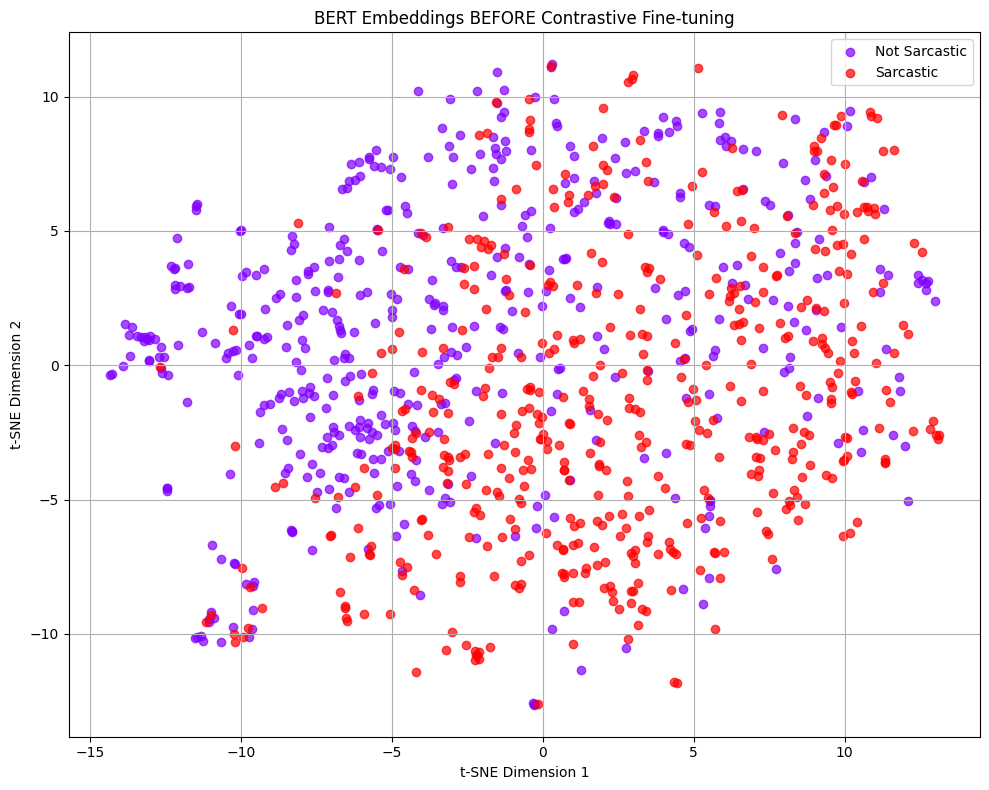


Running t-SNE on embeddings AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.018795


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.289272
[t-SNE] KL divergence after 300 iterations: 1.477494
t-SNE finished for 'after' embeddings.


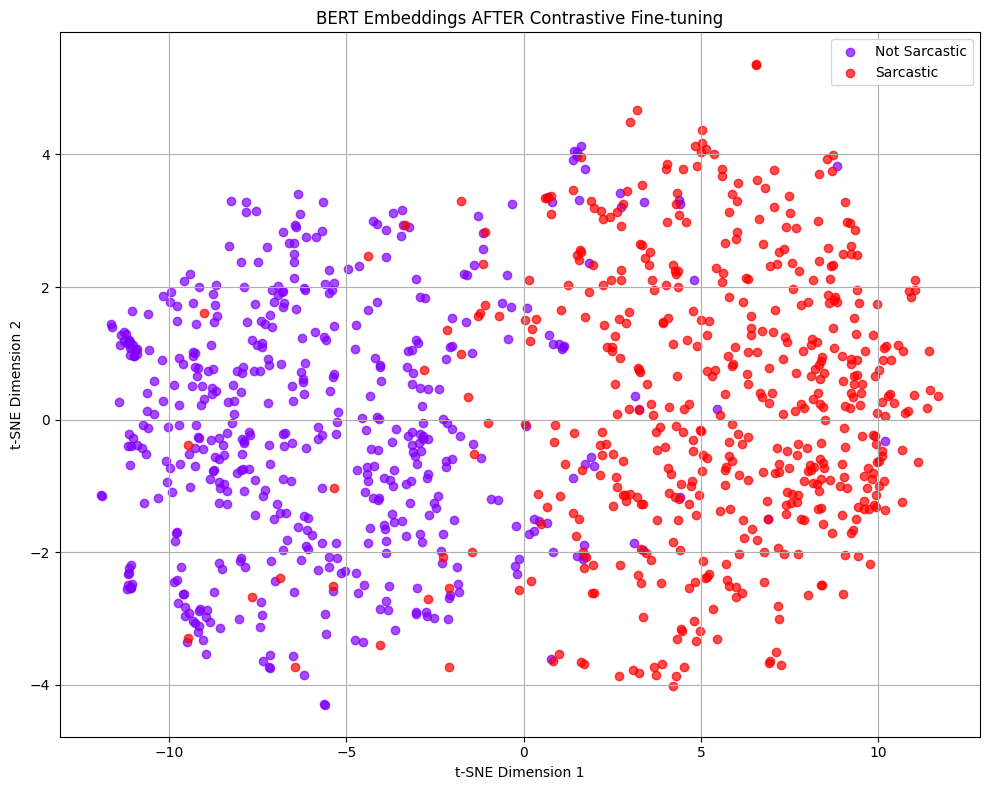

--- Embedding Visualization Finished ---


In [ ]:
def plot_embeddings(embeddings_2d, labels, title):
    """Plots 2D embeddings with labels.
       Assumes embeddings_2d and labels are already aligned and potentially sampled."""
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'} # Assuming 0/1 labels

    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[color], # Scatter expects a list of colors even for one color
                    label=label_map.get(label, f"Class {label}"),
                    alpha=0.7)

    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() for interactive display


# Prepare data for t-SNE (use a subset if specified) - CORRECTED SAMPLING
if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
    print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
    # Ensure sample size is not larger than the available data
    actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
    if actual_sample_size != VISUALIZATION_SAMPLE_SIZE:
        print(f"Warning: Requested sample size {VISUALIZATION_SAMPLE_SIZE} > available data {len(y_test)}. Using {actual_sample_size}.")
    sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)

    # Sample high-dimensional embeddings AND labels using the same indices
    embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
    embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
    labels_for_plot = y_test[sample_indices] # Sample the labels!
else:
    print("Using all test points for t-SNE.")
    # No sampling needed
    embeddings_to_tsne_before = X_bert_test_before_ft
    embeddings_to_tsne_after = X_bert_test_after_ft
    labels_for_plot = y_test # Use all labels


# Apply t-SNE to "BEFORE" embeddings
print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
print("t-SNE finished for 'before' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive Fine-tuning")


# Apply t-SNE to "AFTER" embeddings
print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
print("t-SNE finished for 'after' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive Fine-tuning")

print("--- Embedding Visualization Finished ---")


Extracting linguistic features...
Linguistic TRAIN features shape: (21464, 17)
Linguistic TEST features shape: (7155, 17)

Combining Fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling TRAIN shape: (21464, 785)
Combined BERT+Ling TEST shape: (7155, 785)

Scaling combined BERT+Ling features...
Scaled Combined BERT+Ling TRAIN features shape (sparse): (21464, 785)
Scaled Combined BERT+Ling TEST features shape (sparse): (7155, 785)

Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)

Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Training Downstream Classifier (Logistic Regression) ---
Training Logistic Regression model...
Training finished in 31.15s

Evaluating Logistic Regression model on the test set...
Evaluation finished in 0.06s

--- Classification Results ---

Classification Report:
               precision    recall

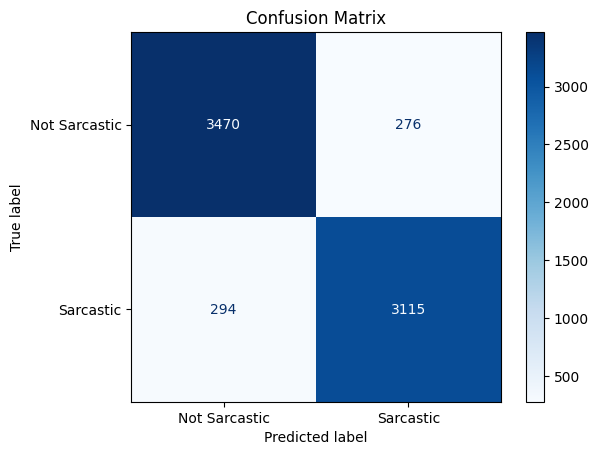


Macro F1 Score: 0.9201
Weighted F1 Score: 0.9203

--- Script Finished ---


In [ ]:
# --- Feature Generation (using fine-tuned BERT for downstream task) ---

# 1. Linguistic Features for TRAIN and TEST sets
print("\nExtracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# Ensure all ling features exist, fill missing with 0 or mean if appropriate
for col in ling_feature_names:
    if col not in df_train.columns:
        print(f"Warning: Linguistic feature '{col}' not found in training data. Filling with 0.")
        df_train[col] = 0
    if col not in df_test.columns:
        print(f"Warning: Linguistic feature '{col}' not found in test data. Filling with 0.")
        df_test[col] = 0

# Handle potential NaN values that might arise if features weren't generated correctly
df_train[ling_feature_names] = df_train[ling_feature_names].fillna(0)
df_test[ling_feature_names] = df_test[ling_feature_names].fillna(0)

X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print("Linguistic TRAIN features shape:", X_ling_train.shape)
print("Linguistic TEST features shape:", X_ling_test.shape)

# 2. Combine Fine-tuned BERT [CLS] + Linguistic Features (Dense) for TRAIN and TEST
print("\nCombining Fine-tuned BERT [CLS] and linguistic features...")
# Use the 'after_ft' embeddings generated earlier
X_gling_train = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test = np.hstack([X_bert_test_after_ft, X_ling_test])
print("Combined BERT+Ling TRAIN shape:", X_gling_train.shape)
print("Combined BERT+Ling TEST shape:", X_gling_test.shape)

# --- Feature Scaling (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nScaling combined BERT+Ling features...")
# Scale only the combined dense features before adding sparse TF-IDF
scaler = StandardScaler()
X_gling_train_scaled = scaler.fit_transform(X_gling_train) # Fit ONLY on training data
X_gling_test_scaled = scaler.transform(X_gling_test)   # Transform test data

# Convert scaled dense features to sparse format for hstack
X_train_sparse_scaled_gling = csr_matrix(X_gling_train_scaled)
X_test_sparse_scaled_gling = csr_matrix(X_gling_test_scaled)
print("Scaled Combined BERT+Ling TRAIN features shape (sparse):", X_train_sparse_scaled_gling.shape)
print("Scaled Combined BERT+Ling TEST features shape (sparse):", X_test_sparse_scaled_gling.shape)

# --- TF-IDF Features (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer()

# Fit TF-IDF ONLY on the training text data
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("\nCombining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled_gling])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled_gling])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\n--- Training Downstream Classifier (Logistic Regression) ---")

lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE)
print("Training Logistic Regression model...")
train_start_time = time.time()
lr.fit(X_train_combined, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating Logistic Regression model on the test set...")
eval_start_time = time.time()
y_pred = lr.predict(X_test_combined)
y_pred_proba = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1 (sarcastic)
print(f"Evaluation finished in {time.time() - eval_start_time:.2f}s")

print("\n--- Classification Results ---")
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions/support
print(classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

print("\nConfusion Matrix:")
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
except ImportError:
    print("Confusion Matrix (sklearn.metrics.ConfusionMatrixDisplay not available):")
    print(confusion_matrix(y_test, y_pred, labels=lr.classes_))


print(f"\nMacro F1 Score: {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

print("\n--- Script Finished ---")

## tf-idf

Loaded data with 28619 samples.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64

Fitting TF-IDF Vectorizer on ALL data (used for 'tfidf' sampling proxy)...
TF-IDF Matrix shape (full data): (28619, 26321)

Splitting data into train/test sets...
Train set size: 21464, Test set size: 7155
TF-IDF Train matrix shape (for sampling): (21464, 26321)

Loading tokenizer and base BERT model: bert-base-uncased
Using device: cuda

Generating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...
  Generating embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 36.9s
    Processed batch 100/224 (44.6%) | ETA: 26.7s
    Processed batch 150/224 (67.0%) | ETA: 16.1s
    Processed batch 200/224 (89.3%) | ETA: 5.3s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 49.42s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)

Preparing for contrastive fine-tuning using '

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757385
[t-SNE] KL divergence after 300 iterations: 2.132796
t-SNE finished for 'before' embeddings.


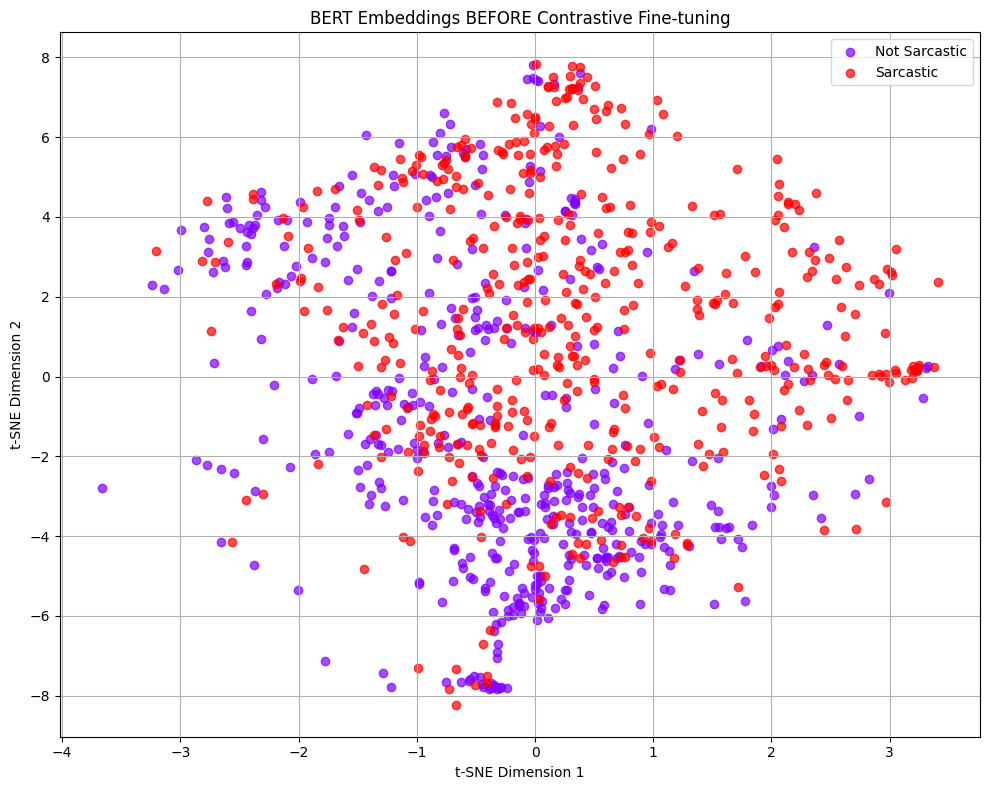


Running t-SNE on embeddings AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.705974


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.404076
[t-SNE] KL divergence after 300 iterations: 1.766206
t-SNE finished for 'after' embeddings.


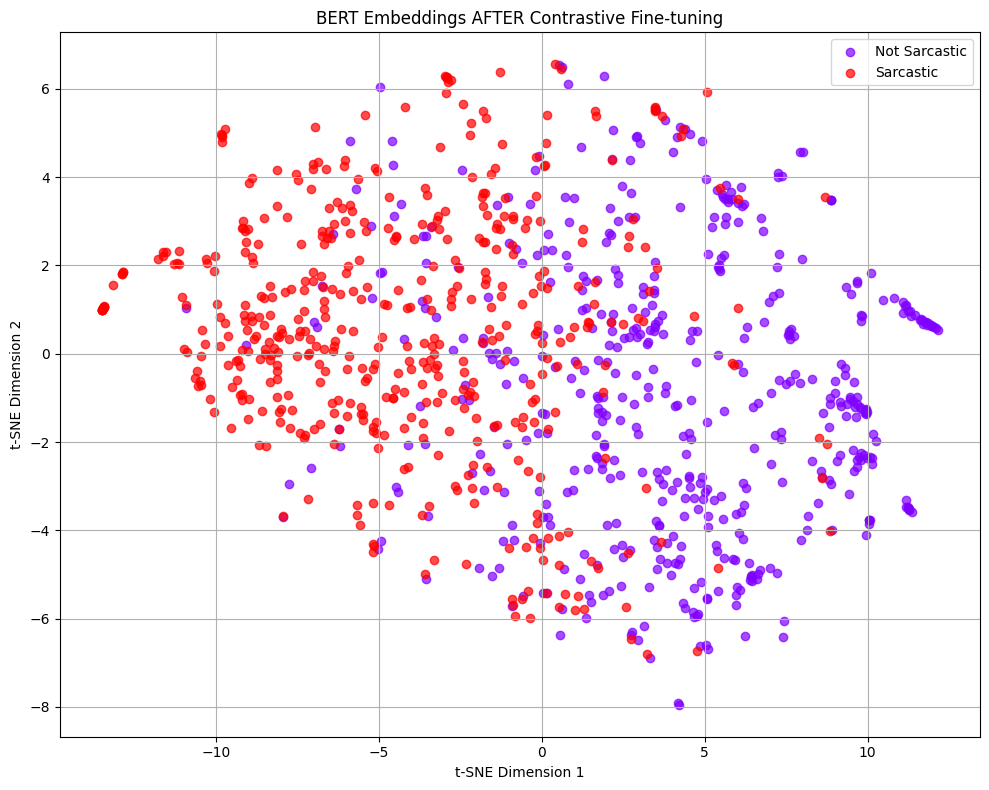

--- Embedding Visualization Finished ---
Script finished. Sampling strategy used: 'tfidf'.


In [51]:
"""
Sarcasm Detection with Contrastive Fine-tuning (Selectable Sampling) and Visualization

This script demonstrates sarcasm detection using:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss),
   with a choice between 'random' or 'tfidf' proxy hard triplet sampling.
2. TF-IDF features (used for tfidf sampling proxy).
It also includes t-SNE visualization of BERT embeddings before and after
contrastive fine-tuning.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, pairwise
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import random
import time
from collections import defaultdict

# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16 # Reduced batch size often needed due to lookup overhead, adjust based on GPU memory
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# --- CHOOSE SAMPLING STRATEGY ---
SAMPLING_STRATEGY = 'tfidf'  # Options: 'random', 'tfidf'
# ---------------------------------

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 1
CONTRASTIVE_LR = 2e-5
CONTRASTIVE_MARGIN = 0.5
PROJECTION_DIM = 256

# Visualization Config
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 300
VISUALIZATION_SAMPLE_SIZE = 1000

if 'is_sarcastic' not in df.columns or 'clean_headline' not in df.columns:
     raise ValueError("DataFrame must contain 'is_sarcastic' and 'clean_headline' columns.")
df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str).fillna('')
df = df[df['clean_headline'].str.len() > 0]
df = df.reset_index(drop=True)
print(f"Loaded data with {len(df)} samples.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")

# --- TF-IDF Vectorizer (Needed for 'tfidf' strategy) ---
# We compute this even if 'random' is selected, for simplicity. Overhead is small.
print("\nFitting TF-IDF Vectorizer on ALL data (used for 'tfidf' sampling proxy)...")
tfidf_vectorizer = TfidfVectorizer()
all_texts = df['clean_headline'].tolist()
tfidf_matrix_full = tfidf_vectorizer.fit_transform(all_texts)
print("TF-IDF Matrix shape (full data):", tfidf_matrix_full.shape)

# --- Split Data ---
print("\nSplitting data into train/test sets...")
train_indices, test_indices = train_test_split(
    df.index, stratify=df['is_sarcastic'], random_state=RANDOM_STATE
)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values

# Slice the TF-IDF matrix (needed only if strategy is 'tfidf', but harmless otherwise)
tfidf_matrix_train = tfidf_matrix_full[train_indices]
# tfidf_matrix_test = tfidf_matrix_full[test_indices] # Not used in this script flow

print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")
if SAMPLING_STRATEGY == 'tfidf':
    print(f"TF-IDF Train matrix shape (for sampling): {tfidf_matrix_train.shape}")

# --- Load Tokenizer and BERT Model ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME) # For 'before' embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_base.to(device)
print(f"Using device: {device}")

# --- Embedding Function ---
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    all_cls_embeddings = []
    model.eval()
    num_samples = len(texts)
    print(f"  Generating embeddings for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()
    for i in range(0, num_samples, batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_texts = [text if isinstance(text, str) and len(text) > 0 else "[PAD]" for text in batch_texts]
        if not batch_texts: continue

        inputs = tokenizer(
            batch_texts, return_tensors='pt', padding='max_length',
            truncation=True, max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_cls_embeddings.append(cls_embeddings.cpu().numpy())

        if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches:
             progress = (i // batch_size + 1) / num_batches
             elapsed = time.time() - start_time
             eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
             print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")

    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")
    if not all_cls_embeddings:
        hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768
        return np.array([]).reshape(0, hidden_size)
    return np.vstack(all_cls_embeddings)

# --- Generate Embeddings BEFORE Fine-tuning ---
print("\nGenerating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...")
X_bert_test_before_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(), bert_model_base, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)

# --- Contrastive Learning Setup ---

# Dataset Class for RANDOM Sampling (Original)
class TripletSarcasmDataset(Dataset):
    """Dataset for generating random triplets (anchor, positive, negative)."""
    def __init__(self, dataframe, tokenizer, max_length):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2:
            raise ValueError("Contrastive learning requires at least two classes.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]

        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices:
            positive_index = index # Fallback: use anchor itself
        else:
            positive_index = random.choice(possible_positive_indices)
        positive_text = self.texts[positive_index]

        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        # Handle case where negative label might have no samples (shouldn't happen with good split)
        if not self.label_to_indices[negative_label]:
             # Fallback: choose any index with a different label
             possible_negative_indices = [i for i, lbl in enumerate(self.labels) if lbl != anchor_label]
             if not possible_negative_indices: raise ValueError("Cannot find any negative samples.")
             negative_index = random.choice(possible_negative_indices)
        else:
             negative_index = random.choice(self.label_to_indices[negative_label])
        negative_text = self.texts[negative_index]

        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }

# Dataset Class for TF-IDF Proxy Hard Mining
class TripletSarcasmDatasetTFIDF(Dataset):
    """Dataset generating triplets using TF-IDF proxy hard mining."""
    def __init__(self, dataframe, tokenizer, max_length, tfidf_matrix):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tfidf_matrix = tfidf_matrix
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx in range(len(self.df)):
            self.label_to_indices[self.labels[idx]].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2: raise ValueError("Requires >= 2 classes.")
        if self.tfidf_matrix.shape[0] != len(self.df): raise ValueError("TF-IDF matrix rows mismatch.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]
        anchor_tfidf_vec = self.tfidf_matrix[index]

        # Select Positive (Lowest TF-IDF Similarity)
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices:
            positive_index = index
        else:
            positive_tfidf_vecs = self.tfidf_matrix[possible_positive_indices]
            similarities = pairwise.cosine_similarity(anchor_tfidf_vec, positive_tfidf_vecs).flatten()
            # Handle cases where all similarities might be NaN (e.g., zero vectors)
            if np.isnan(similarities).all():
                 positive_index = random.choice(possible_positive_indices) # Fallback to random
            else:
                 hardest_positive_local_idx = np.nanargmin(similarities) # Use nanargmin
                 positive_index = possible_positive_indices[hardest_positive_local_idx]
        positive_text = self.texts[positive_index]

        # Select Negative (Highest TF-IDF Similarity)
        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        possible_negative_indices = self.label_to_indices[negative_label]
        if not possible_negative_indices: # Fallback if chosen neg label empty
             all_negative_indices = [i for l, idxs in self.label_to_indices.items() if l != anchor_label for i in idxs]
             if not all_negative_indices: raise ValueError("Cannot find any negative samples.")
             possible_negative_indices = all_negative_indices

        negative_tfidf_vecs = self.tfidf_matrix[possible_negative_indices]
        similarities = pairwise.cosine_similarity(anchor_tfidf_vec, negative_tfidf_vecs).flatten()
        # Handle cases where all similarities might be NaN
        if np.isnan(similarities).all():
            negative_index = random.choice(possible_negative_indices) # Fallback to random
        else:
            hardest_negative_local_idx = np.nanargmax(similarities) # Use nanargmax
            negative_index = possible_negative_indices[hardest_negative_local_idx]
        negative_text = self.texts[negative_index]

        # Tokenize
        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }


# Contrastive Model Wrapper
class ContrastiveBERT(nn.Module):
    def __init__(self, bert_model, projection_dim=None):
        super().__init__()
        self.bert = bert_model
        self.projection_dim = projection_dim
        self.config = bert_model.config
        if self.projection_dim:
            self.projection_head = nn.Sequential(
                nn.Linear(self.config.hidden_size, self.config.hidden_size), nn.ReLU(),
                nn.Linear(self.config.hidden_size, self.projection_dim)
            )
        else: self.projection_head = nn.Identity()

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        if token_type_ids is not None:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.projection_head(cls_embedding)

# Fine-tuning Function
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, loss_fn, device, epochs):
    model.train()
    start_time = time.time()
    print("\n--- Starting Contrastive Fine-tuning ---")
    for epoch in range(epochs):
        epoch_loss = 0.0; epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")
        for i, batch in enumerate(dataloader):
            if not batch['anchor']: continue
            anchor_inputs = {k: v.to(device) for k, v in batch['anchor'].items()}
            positive_inputs = {k: v.to(device) for k, v in batch['positive'].items()}
            negative_inputs = {k: v.to(device) for k, v in batch['negative'].items()}
            optimizer.zero_grad()
            anchor_emb = model(**anchor_inputs)
            positive_emb = model(**positive_inputs)
            negative_emb = model(**negative_inputs)
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
            if (i + 1) % 50 == 0 or i == len(dataloader) - 1:
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | LR: {current_lr:.2e}")
        avg_epoch_loss = epoch_loss / len(dataloader) if len(dataloader) > 0 else 0
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_epoch_loss:.4f} | Time: {time.time() - epoch_start_time:.2f}s")
    print(f"--- Contrastive Fine-tuning Finished ({time.time() - start_time:.2f}s) ---")

# --- Prepare for Contrastive Fine-tuning ---
print(f"\nPreparing for contrastive fine-tuning using '{SAMPLING_STRATEGY}' strategy...")

# --- Select and Instantiate Dataset based on Strategy ---
if SAMPLING_STRATEGY == 'random':
    train_triplet_dataset = TripletSarcasmDataset(
        df_train, tokenizer, MAX_LENGTH
    )
    print("Using Random Triplet Sampling.")
elif SAMPLING_STRATEGY == 'tfidf':
    train_triplet_dataset = TripletSarcasmDatasetTFIDF(
        df_train, tokenizer, MAX_LENGTH, tfidf_matrix_train # Pass TF-IDF matrix
    )
    print("Using TF-IDF Proxy Hard Mining Triplet Sampling.")
else:
    raise ValueError(f"Invalid SAMPLING_STRATEGY: '{SAMPLING_STRATEGY}'. Choose 'random' or 'tfidf'.")
# --------------------------------------------------------

train_triplet_dataloader = DataLoader(
    train_triplet_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True if device == torch.device("cuda") else False
)

# Create a *new* model instance for fine-tuning
bert_model_to_finetune = AutoModel.from_pretrained(BERT_MODEL_NAME)
contrastive_model = ContrastiveBERT(bert_model_to_finetune, projection_dim=PROJECTION_DIM).to(device)

# Loss, Optimizer, Scheduler
triplet_loss_fn = nn.TripletMarginLoss(margin=CONTRASTIVE_MARGIN, p=2)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
total_steps = len(train_triplet_dataloader) * CONTRASTIVE_EPOCHS
num_warmup_steps = int(0.1 * len(train_triplet_dataloader))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# --- Run Contrastive Fine-tuning ---
fine_tune_bert_contrastive(contrastive_model, train_triplet_dataloader, optimizer, scheduler, triplet_loss_fn, device, CONTRASTIVE_EPOCHS)

# Extract the fine-tuned base BERT model
fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval()
fine_tuned_base_bert_model.to(device)

# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings for TRAIN set...")
X_bert_train_after_ft = get_bert_cls_embeddings(
    df_train['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)

print("\nGenerating Fine-tuned BERT [CLS] embeddings for TEST set...")
X_bert_test_after_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)

# --- Visualization Section ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")
def plot_embeddings(embeddings_2d, labels, title):
    """Plots 2D embeddings with labels.
       Assumes embeddings_2d and labels are already aligned and potentially sampled."""
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'} # Assuming 0/1 labels

    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[color], # Scatter expects a list of colors even for one color
                    label=label_map.get(label, f"Class {label}"),
                    alpha=0.7)

    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() for interactive display


# Prepare data for t-SNE (use a subset if specified) - CORRECTED SAMPLING
if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
    print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
    # Ensure sample size is not larger than the available data
    actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
    if actual_sample_size != VISUALIZATION_SAMPLE_SIZE:
        print(f"Warning: Requested sample size {VISUALIZATION_SAMPLE_SIZE} > available data {len(y_test)}. Using {actual_sample_size}.")
    sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)

    # Sample high-dimensional embeddings AND labels using the same indices
    embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
    embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
    labels_for_plot = y_test[sample_indices] # Sample the labels!
else:
    print("Using all test points for t-SNE.")
    # No sampling needed
    embeddings_to_tsne_before = X_bert_test_before_ft
    embeddings_to_tsne_after = X_bert_test_after_ft
    labels_for_plot = y_test # Use all labels


# Apply t-SNE to "BEFORE" embeddings
print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
print("t-SNE finished for 'before' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive Fine-tuning")


# Apply t-SNE to "AFTER" embeddings
print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
print("t-SNE finished for 'after' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive Fine-tuning")

print("--- Embedding Visualization Finished ---")
print(f"Script finished. Sampling strategy used: '{SAMPLING_STRATEGY}'.")


Extracting linguistic features...
Linguistic TRAIN features shape: (21464, 17)
Linguistic TEST features shape: (7155, 17)

Combining Fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling TRAIN shape: (21464, 785)
Combined BERT+Ling TEST shape: (7155, 785)

Scaling combined BERT+Ling features...
Scaled Combined BERT+Ling TRAIN features shape (sparse): (21464, 785)
Scaled Combined BERT+Ling TEST features shape (sparse): (7155, 785)

Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)

Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Training Downstream Classifier (Logistic Regression) ---
Training Logistic Regression model...
Training finished in 43.80s

Evaluating Logistic Regression model on the test set...
Evaluation finished in 0.03s

--- Classification Results ---

Classification Report:
               precision    recall

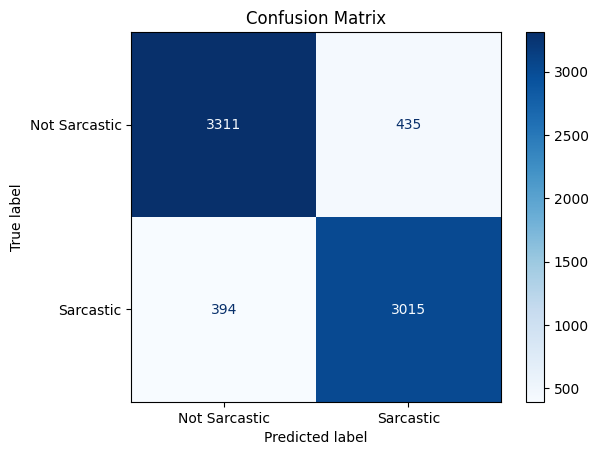


Macro F1 Score: 0.8839
Weighted F1 Score: 0.8842

--- Script Finished ---


In [53]:
# --- Feature Generation (using fine-tuned BERT for downstream task) ---

# 1. Linguistic Features for TRAIN and TEST sets
print("\nExtracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# Ensure all ling features exist, fill missing with 0 or mean if appropriate
for col in ling_feature_names:
    if col not in df_train.columns:
        print(f"Warning: Linguistic feature '{col}' not found in training data. Filling with 0.")
        df_train[col] = 0
    if col not in df_test.columns:
        print(f"Warning: Linguistic feature '{col}' not found in test data. Filling with 0.")
        df_test[col] = 0

# Handle potential NaN values that might arise if features weren't generated correctly
df_train[ling_feature_names] = df_train[ling_feature_names].fillna(0)
df_test[ling_feature_names] = df_test[ling_feature_names].fillna(0)

X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print("Linguistic TRAIN features shape:", X_ling_train.shape)
print("Linguistic TEST features shape:", X_ling_test.shape)

# 2. Combine Fine-tuned BERT [CLS] + Linguistic Features (Dense) for TRAIN and TEST
print("\nCombining Fine-tuned BERT [CLS] and linguistic features...")
# Use the 'after_ft' embeddings generated earlier
X_gling_train = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test = np.hstack([X_bert_test_after_ft, X_ling_test])
print("Combined BERT+Ling TRAIN shape:", X_gling_train.shape)
print("Combined BERT+Ling TEST shape:", X_gling_test.shape)

# --- Feature Scaling (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nScaling combined BERT+Ling features...")
# Scale only the combined dense features before adding sparse TF-IDF
scaler = StandardScaler()
X_gling_train_scaled = scaler.fit_transform(X_gling_train) # Fit ONLY on training data
X_gling_test_scaled = scaler.transform(X_gling_test)   # Transform test data

# Convert scaled dense features to sparse format for hstack
X_train_sparse_scaled_gling = csr_matrix(X_gling_train_scaled)
X_test_sparse_scaled_gling = csr_matrix(X_gling_test_scaled)
print("Scaled Combined BERT+Ling TRAIN features shape (sparse):", X_train_sparse_scaled_gling.shape)
print("Scaled Combined BERT+Ling TEST features shape (sparse):", X_test_sparse_scaled_gling.shape)

# --- TF-IDF Features (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer()

# Fit TF-IDF ONLY on the training text data
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("\nCombining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled_gling])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled_gling])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\n--- Training Downstream Classifier (Logistic Regression) ---")

lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE)
print("Training Logistic Regression model...")
train_start_time = time.time()
lr.fit(X_train_combined, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating Logistic Regression model on the test set...")
eval_start_time = time.time()
y_pred = lr.predict(X_test_combined)
y_pred_proba = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1 (sarcastic)
print(f"Evaluation finished in {time.time() - eval_start_time:.2f}s")

print("\n--- Classification Results ---")
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions/support
print(classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

print("\nConfusion Matrix:")
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
except ImportError:
    print("Confusion Matrix (sklearn.metrics.ConfusionMatrixDisplay not available):")
    print(confusion_matrix(y_test, y_pred, labels=lr.classes_))


print(f"\nMacro F1 Score: {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

print("\n--- Script Finished ---")

## sentence-transformer

Loaded data with 28619 samples.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64
Using device: cuda

Pre-computing Sentence Transformer embeddings using 'all-MiniLM-L6-v2'...
Splitting data temporarily to get training text for proxy embeddings...
Encoding 21464 training texts for proxy...


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Finished encoding in 5.19s.
Proxy embeddings shape (train set): (21464, 384)

Splitting data into final train/test sets...
Using pre-computed Sentence Transformer proxy embeddings for training set.
Train set size: 21464, Test set size: 7155

Loading tokenizer and base BERT model: bert-base-uncased

Generating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...
  Generating embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 38.6s
    Processed batch 100/224 (44.6%) | ETA: 28.1s
    Processed batch 150/224 (67.0%) | ETA: 16.8s
    Processed batch 200/224 (89.3%) | ETA: 5.4s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 50.06s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)

Preparing for contrastive fine-tuning using 'sentence_transformer' strategy...
Using Sentence Transformer Proxy Hard Mining Triplet Sampling Dataset.

--- Starting Contrastive Fine-tuning ---

Epoch 1/1
  Batch 50

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757385
[t-SNE] KL divergence after 300 iterations: 2.132796
t-SNE finished for 'before'.


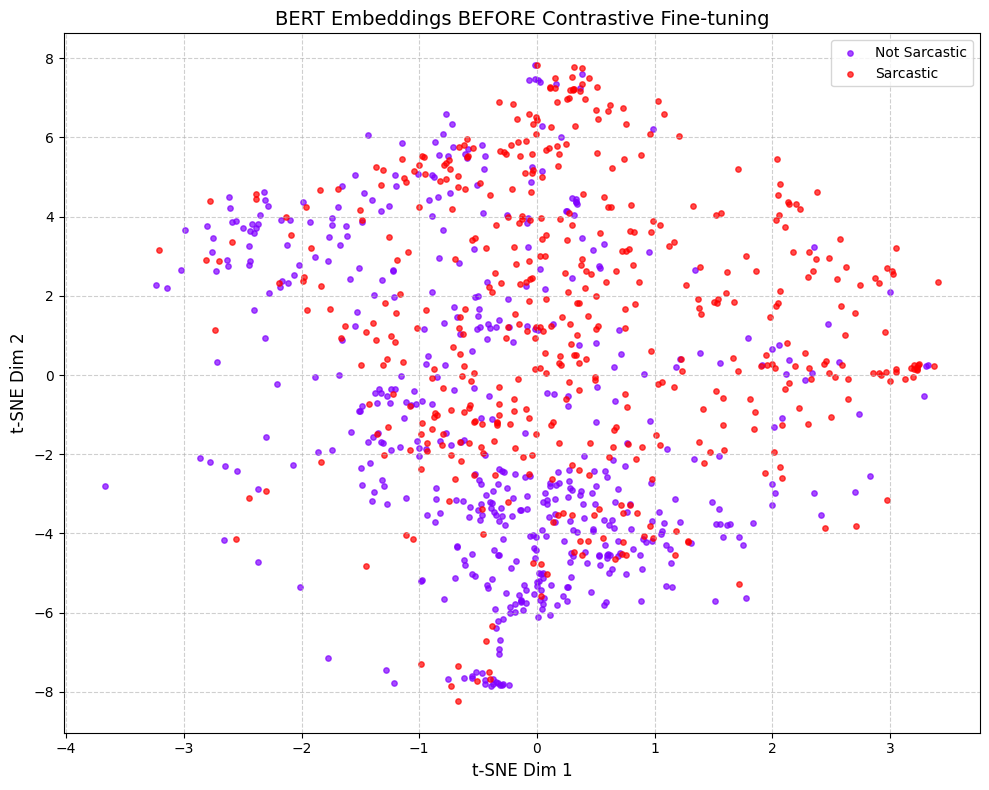


Running t-SNE on embeddings AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.474066


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.676865
[t-SNE] KL divergence after 300 iterations: 1.230742
t-SNE finished for 'after'.


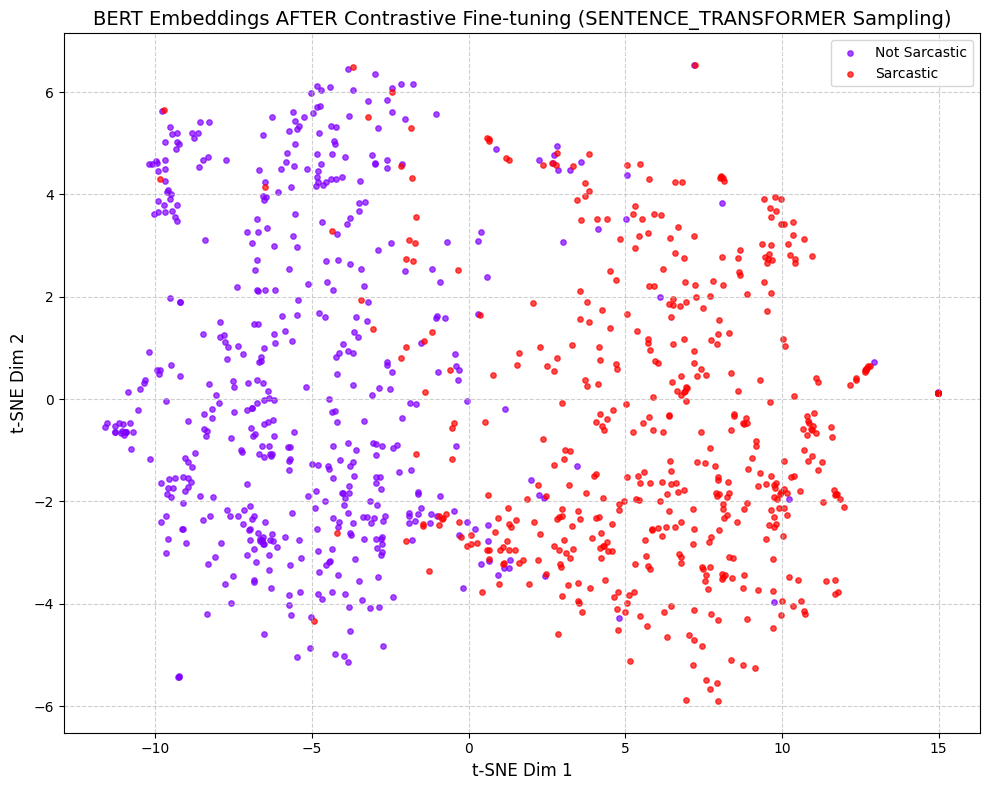

--- Embedding Visualization Finished ---
Script finished. Sampling strategy used: 'sentence_transformer'.


In [ ]:
"""
Sarcasm Detection with Contrastive Fine-tuning (Selectable Sampling: random, tfidf, sentence_transformer) and Visualization

This script demonstrates sarcasm detection using:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss),
   with a choice between 'random', 'tfidf' proxy, or 'sentence_transformer' proxy triplet sampling.
2. TF-IDF features (used only for 'tfidf' sampling proxy).
3. Sentence Transformer embeddings (used only for 'sentence_transformer' sampling proxy).
It also includes t-SNE visualization of BERT embeddings before and after
contrastive fine-tuning.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, pairwise
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import random
import time
from collections import defaultdict
# NEW: Import SentenceTransformer
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("SentenceTransformers library not found. Please install it: pip install sentence-transformers")
    exit()


# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
# NEW: Sentence Transformer model name
SENTENCE_TRANSFORMER_MODEL = 'all-MiniLM-L6-v2' # Common choice, relatively small and fast
MAX_LENGTH = 128
BATCH_SIZE = 16 # Adjust based on GPU memory and strategy
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# --- CHOOSE SAMPLING STRATEGY ---
SAMPLING_STRATEGY = 'sentence_transformer'  # Options: 'random', 'tfidf', 'sentence_transformer'
# ---------------------------------

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 1 # Keep low for testing, increase for real training
CONTRASTIVE_LR = 2e-5
CONTRASTIVE_MARGIN = 0.5
PROJECTION_DIM = 256

# Visualization Config
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 300
VISUALIZATION_SAMPLE_SIZE = 1000

df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str).fillna('')
df = df[df['clean_headline'].str.len() > 0]
df = df.reset_index(drop=True)
print(f"Loaded data with {len(df)} samples.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")


# Set device early
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- Pre-computation for Proxy Methods ---
tfidf_vectorizer = None
tfidf_matrix_train = None
proxy_embeddings_train = None # For Sentence Transformer embeddings

# Fit TF-IDF if needed
if SAMPLING_STRATEGY == 'tfidf':
    print("\nFitting TF-IDF Vectorizer (only for 'tfidf' sampling proxy)...")
    tfidf_vectorizer = TfidfVectorizer()
    # Fit on all data before split for simplicity in Dataset lookup
    # Note: This introduces minor leakage for *sampling* proxy, not model training
    all_texts_tfidf = df['clean_headline'].tolist()
    tfidf_matrix_full = tfidf_vectorizer.fit_transform(all_texts_tfidf)
    print("TF-IDF Matrix shape (full data):", tfidf_matrix_full.shape)

# Pre-compute Sentence Transformer Embeddings if needed
elif SAMPLING_STRATEGY == 'sentence_transformer':
    print(f"\nPre-computing Sentence Transformer embeddings using '{SENTENCE_TRANSFORMER_MODEL}'...")
    st_model = SentenceTransformer(SENTENCE_TRANSFORMER_MODEL, device=device)
    # We only need embeddings for the training set for the proxy dataset
    # Get training text *after* splitting
    print("Splitting data temporarily to get training text for proxy embeddings...")
    temp_train_indices, _ = train_test_split(
        df.index, stratify=df['is_sarcastic'], random_state=RANDOM_STATE# Use same test size as final split
    )
    train_texts_st = df.loc[temp_train_indices, 'clean_headline'].tolist()

    print(f"Encoding {len(train_texts_st)} training texts for proxy...")
    start_time_st = time.time()
    # Encode text to get embeddings. Store on CPU as numpy array for easier handling in dataset.
    proxy_embeddings_train = st_model.encode(
        train_texts_st,
        batch_size=128, # Adjust batch size based on GPU memory
        show_progress_bar=True,
        convert_to_numpy=True # Easier for scikit-learn's cosine_similarity
    )
    print(f"Finished encoding in {time.time() - start_time_st:.2f}s.")
    print("Proxy embeddings shape (train set):", proxy_embeddings_train.shape)
    # Clean up Sentence Transformer model from GPU memory if needed
    del st_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Final Data Split ---
print("\nSplitting data into final train/test sets...")
train_indices, test_indices = train_test_split(
    df.index, stratify=df['is_sarcastic'], random_state=RANDOM_STATE
)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values

# Slice the TF-IDF matrix if 'tfidf' strategy is used
if SAMPLING_STRATEGY == 'tfidf':
    if 'tfidf_matrix_full' not in locals() or tfidf_matrix_full is None:
         raise RuntimeError("TF-IDF matrix was not computed but 'tfidf' strategy was selected.")
    tfidf_matrix_train = tfidf_matrix_full[train_indices]
    print(f"TF-IDF Train matrix shape (for sampling): {tfidf_matrix_train.shape}")
elif SAMPLING_STRATEGY == 'sentence_transformer':
     if proxy_embeddings_train is None:
         raise RuntimeError("Sentence Transformer embeddings required but not computed.")
     # Check if length matches df_train (should match due to using same random_state in temp split)
     if len(proxy_embeddings_train) != len(df_train):
          raise ValueError(f"Proxy embedding length ({len(proxy_embeddings_train)}) doesn't match df_train length ({len(df_train)}). Check splitting consistency.")
     print("Using pre-computed Sentence Transformer proxy embeddings for training set.")


print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")


# --- Load Tokenizer and BERT Model ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME) # For 'before' embeddings
bert_model_base.to(device)


# --- Embedding Function ---
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    # (Identical to previous version)
    all_cls_embeddings = []
    model.eval()
    num_samples = len(texts)
    print(f"  Generating embeddings for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()
    for i in range(0, num_samples, batch_size):
        batch_texts = texts[i:i+batch_size]; batch_texts = [t if isinstance(t, str) and len(t) > 0 else "[PAD]" for t in batch_texts]
        if not batch_texts: continue
        inputs = tokenizer(batch_texts, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length).to(device)
        with torch.no_grad(): outputs = model(**inputs)
        all_cls_embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
        if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches:
             progress = (i // batch_size + 1) / num_batches; elapsed = time.time() - start_time; eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
             print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")
    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")
    if not all_cls_embeddings: hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768; return np.array([]).reshape(0, hidden_size)
    return np.vstack(all_cls_embeddings)


# --- Generate Embeddings BEFORE Fine-tuning ---
print("\nGenerating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...")
X_bert_test_before_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(), bert_model_base, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)


# --- Contrastive Learning Setup ---

# --- Dataset Classes ---

# Dataset Class for RANDOM Triplet Sampling (Renamed for clarity)
class TripletSarcasmDatasetRandom(Dataset):
    # (Identical to previous 'TripletSarcasmDataset')
    def __init__(self, dataframe, tokenizer, max_length):
        self.df=dataframe; self.tokenizer=tokenizer; self.max_length=max_length
        self.labels=dataframe['is_sarcastic'].values; self.texts=dataframe['clean_headline'].tolist()
        self.label_to_indices=defaultdict(list);
        for idx, label in enumerate(self.labels): self.label_to_indices[label].append(idx)
        self.unique_labels=sorted(list(self.label_to_indices.keys()));
        if len(self.unique_labels) < 2: raise ValueError("Requires >= 2 classes.")
    def __len__(self): return len(self.df)
    def __getitem__(self, index):
        anchor_text=self.texts[index]; anchor_label=self.labels[index]
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        positive_index = index if not possible_positive_indices else random.choice(possible_positive_indices)
        positive_text=self.texts[positive_index]
        negative_label=random.choice([l for l in self.unique_labels if l != anchor_label])
        possible_negative_indices=self.label_to_indices[negative_label]
        if not possible_negative_indices:
             all_neg_indices=[i for i, lbl in enumerate(self.labels) if lbl != anchor_label]
             if not all_neg_indices: raise ValueError("Cannot find any negative samples.")
             negative_index=random.choice(all_neg_indices)
        else: negative_index=random.choice(possible_negative_indices)
        negative_text=self.texts[negative_index]
        # Tokenize
        anchor_inputs=self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs=self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs=self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        return {'anchor':{k:v.squeeze(0) for k,v in anchor_inputs.items()}, 'positive':{k:v.squeeze(0) for k,v in positive_inputs.items()}, 'negative':{k:v.squeeze(0) for k,v in negative_inputs.items()}}


# Dataset Class for TF-IDF Proxy Hard Mining
class TripletSarcasmDatasetTFIDF(Dataset):
    # (Identical to previous version)
    def __init__(self, dataframe, tokenizer, max_length, tfidf_matrix):
        self.df=dataframe; self.tokenizer=tokenizer; self.max_length=max_length; self.tfidf_matrix=tfidf_matrix
        self.labels=dataframe['is_sarcastic'].values; self.texts=dataframe['clean_headline'].tolist()
        self.label_to_indices=defaultdict(list);
        for idx in range(len(self.df)): self.label_to_indices[self.labels[idx]].append(idx)
        self.unique_labels=sorted(list(self.label_to_indices.keys()));
        if len(self.unique_labels) < 2: raise ValueError("Requires >= 2 classes.")
        if self.tfidf_matrix.shape[0] != len(self.df): raise ValueError("TF-IDF matrix rows mismatch.")
    def __len__(self): return len(self.df)
    def __getitem__(self, index):
        anchor_text=self.texts[index]; anchor_label=self.labels[index]; anchor_tfidf_vec=self.tfidf_matrix[index]
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices: positive_index = index
        else:
            positive_tfidf_vecs = self.tfidf_matrix[possible_positive_indices]
            similarities = pairwise.cosine_similarity(anchor_tfidf_vec, positive_tfidf_vecs).flatten()
            if np.isnan(similarities).all(): positive_index = random.choice(possible_positive_indices)
            else: hardest_positive_local_idx = np.nanargmin(similarities); positive_index = possible_positive_indices[hardest_positive_local_idx]
        positive_text = self.texts[positive_index]
        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        possible_negative_indices = self.label_to_indices[negative_label]
        if not possible_negative_indices:
             all_neg_indices = [i for l, idxs in self.label_to_indices.items() if l != anchor_label for i in idxs]
             if not all_neg_indices: raise ValueError("Cannot find any negative samples.")
             possible_negative_indices = all_neg_indices
        negative_tfidf_vecs = self.tfidf_matrix[possible_negative_indices]
        similarities = pairwise.cosine_similarity(anchor_tfidf_vec, negative_tfidf_vecs).flatten()
        if np.isnan(similarities).all(): negative_index = random.choice(possible_negative_indices)
        else: hardest_negative_local_idx = np.nanargmax(similarities); negative_index = possible_negative_indices[hardest_negative_local_idx]
        negative_text = self.texts[negative_index]
        # Tokenize
        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        return {'anchor':{k:v.squeeze(0) for k,v in anchor_inputs.items()}, 'positive':{k:v.squeeze(0) for k,v in positive_inputs.items()}, 'negative':{k:v.squeeze(0) for k,v in negative_inputs.items()}}


# NEW: Dataset Class for Sentence Transformer Proxy Hard Mining
class TripletSarcasmDatasetSentenceTransformer(Dataset):
    """Dataset generating triplets using Sentence Transformer proxy embeddings."""
    def __init__(self, dataframe, tokenizer, max_length, proxy_embeddings):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.proxy_embeddings = proxy_embeddings # Precomputed ST embeddings
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx in range(len(self.df)):
            self.label_to_indices[self.labels[idx]].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2: raise ValueError("Requires >= 2 classes.")
        if self.proxy_embeddings.shape[0] != len(self.df):
             raise ValueError(f"Proxy embedding rows ({self.proxy_embeddings.shape[0]}) do not match dataframe length ({len(self.df)}).")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]
        # Reshape anchor proxy embedding for pairwise similarity calculation
        anchor_proxy_emb = self.proxy_embeddings[index].reshape(1, -1)

        # Select Positive (Lowest Proxy Cosine Similarity)
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices:
            positive_index = index
        else:
            positive_proxy_embs = self.proxy_embeddings[possible_positive_indices]
            similarities = pairwise.cosine_similarity(anchor_proxy_emb, positive_proxy_embs).flatten()
            if np.isnan(similarities).all():
                 positive_index = random.choice(possible_positive_indices) # Fallback
            else:
                 hardest_positive_local_idx = np.nanargmin(similarities)
                 positive_index = possible_positive_indices[hardest_positive_local_idx]
        positive_text = self.texts[positive_index]

        # Select Negative (Highest Proxy Cosine Similarity)
        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        possible_negative_indices = self.label_to_indices[negative_label]
        if not possible_negative_indices: # Fallback
             all_negative_indices = [i for l, idxs in self.label_to_indices.items() if l != anchor_label for i in idxs]
             if not all_negative_indices: raise ValueError("Cannot find any negative samples.")
             possible_negative_indices = all_negative_indices

        negative_proxy_embs = self.proxy_embeddings[possible_negative_indices]
        similarities = pairwise.cosine_similarity(anchor_proxy_emb, negative_proxy_embs).flatten()
        if np.isnan(similarities).all():
            negative_index = random.choice(possible_negative_indices) # Fallback
        else:
            hardest_negative_local_idx = np.nanargmax(similarities)
            negative_index = possible_negative_indices[hardest_negative_local_idx]
        negative_text = self.texts[negative_index]

        # Tokenize the *original text* for the main model
        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }


# Contrastive Model Wrapper (Same as before)
class ContrastiveBERT(nn.Module):
    def __init__(self, bert_model, projection_dim=None):
        super().__init__(); self.bert=bert_model; self.projection_dim=projection_dim; self.config=bert_model.config
        if self.projection_dim: self.projection_head = nn.Sequential(nn.Linear(self.config.hidden_size, self.config.hidden_size), nn.ReLU(), nn.Linear(self.config.hidden_size, self.projection_dim))
        else: self.projection_head = nn.Identity()
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        bert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
        if token_type_ids is not None and 'token_type_ids' in self.bert.forward.__code__.co_varnames: bert_inputs['token_type_ids'] = token_type_ids
        outputs=self.bert(**bert_inputs); cls_embedding=outputs.last_hidden_state[:, 0, :]; return self.projection_head(cls_embedding)


# Fine-tuning Function (Unchanged - works for all triplet datasets)
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, loss_fn, device, epochs):
    # (Identical to previous version)
    model.train(); start_time = time.time(); print("\n--- Starting Contrastive Fine-tuning ---")
    for epoch in range(epochs):
        epoch_loss = 0.0; epoch_start_time = time.time(); print(f"\nEpoch {epoch+1}/{epochs}")
        for i, batch in enumerate(dataloader):
            # Check if batch is empty or invalid (robustness)
            if not batch or 'anchor' not in batch or not batch['anchor']: print(f"Warning: Skipping invalid batch {i+1}"); continue

            anchor_inputs = {k: v.to(device) for k, v in batch['anchor'].items()}
            positive_inputs = {k: v.to(device) for k, v in batch['positive'].items()}
            negative_inputs = {k: v.to(device) for k, v in batch['negative'].items()}
            optimizer.zero_grad()
            anchor_emb = model(**anchor_inputs); positive_emb = model(**positive_inputs); negative_emb = model(**negative_inputs)
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            if torch.isnan(loss): print(f"Warning: NaN loss detected at batch {i+1}. Skipping backward pass."); continue # Skip step if loss is NaN
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0); optimizer.step(); scheduler.step()
            epoch_loss += loss.item()
            if (i + 1) % 50 == 0 or i == len(dataloader) - 1:
                current_lr = scheduler.get_last_lr()[0]; print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | LR: {current_lr:.2e}")
        avg_epoch_loss = epoch_loss / len(dataloader) if len(dataloader) > 0 else 0
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_epoch_loss:.4f} | Time: {time.time() - epoch_start_time:.2f}s")
    print(f"--- Contrastive Fine-tuning Finished ({time.time() - start_time:.2f}s) ---")


# --- Prepare for Contrastive Fine-tuning ---
print(f"\nPreparing for contrastive fine-tuning using '{SAMPLING_STRATEGY}' strategy...")

# --- Select and Instantiate Dataset based on Strategy ---
if SAMPLING_STRATEGY == 'random':
    train_dataset = TripletSarcasmDatasetRandom(df_train, tokenizer, MAX_LENGTH)
    print("Using Random Triplet Sampling Dataset.")
elif SAMPLING_STRATEGY == 'tfidf':
    if tfidf_matrix_train is None: raise ValueError("TF-IDF matrix required but not computed.")
    train_dataset = TripletSarcasmDatasetTFIDF(df_train, tokenizer, MAX_LENGTH, tfidf_matrix_train)
    print("Using TF-IDF Proxy Hard Mining Triplet Sampling Dataset.")
elif SAMPLING_STRATEGY == 'sentence_transformer':
    if proxy_embeddings_train is None: raise ValueError("Sentence Transformer embeddings required but not computed.")
    train_dataset = TripletSarcasmDatasetSentenceTransformer(df_train, tokenizer, MAX_LENGTH, proxy_embeddings_train)
    print("Using Sentence Transformer Proxy Hard Mining Triplet Sampling Dataset.")
else:
    raise ValueError(f"Invalid SAMPLING_STRATEGY: '{SAMPLING_STRATEGY}'. Choose 'random', 'tfidf', or 'sentence_transformer'.")
# --------------------------------------------------------

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True if device == torch.device("cuda") else False
)

# Create a *new* model instance for fine-tuning
bert_model_to_finetune = AutoModel.from_pretrained(BERT_MODEL_NAME)
contrastive_model = ContrastiveBERT(bert_model_to_finetune, projection_dim=PROJECTION_DIM).to(device)

# Loss, Optimizer, Scheduler
triplet_loss_fn = nn.TripletMarginLoss(margin=CONTRASTIVE_MARGIN, p=2, reduction='mean')
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
total_steps = len(train_dataloader) * CONTRASTIVE_EPOCHS
num_warmup_steps = int(0.1 * len(train_dataloader))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# --- Run Contrastive Fine-tuning ---
fine_tune_bert_contrastive(contrastive_model, train_dataloader, optimizer, scheduler, triplet_loss_fn, device, CONTRASTIVE_EPOCHS)

# Extract the fine-tuned base BERT model
fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval()
fine_tuned_base_bert_model.to(device)

# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings for TRAIN set...")
X_bert_train_after_ft = get_bert_cls_embeddings(
    df_train['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)

print("\nGenerating Fine-tuned BERT [CLS] embeddings for TEST set...")
X_bert_test_after_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)


# --- (Optional) Classifier Training and Evaluation ---
# (No changes needed here, but added strategy name to printout)
if X_bert_train_after_ft.shape[0] > 0 and X_bert_test_after_ft.shape[0] > 0:
    print("\nTraining Logistic Regression classifier on Fine-tuned TRAIN embeddings...")
    scaler_bert = StandardScaler()
    X_bert_train_scaled = scaler_bert.fit_transform(X_bert_train_after_ft)
    X_bert_test_scaled = scaler_bert.transform(X_bert_test_after_ft)
    logreg_clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, C=0.1, class_weight='balanced')
    logreg_clf.fit(X_bert_train_scaled, y_train)
    print("\nEvaluating classifier on TEST set...")
    y_pred = logreg_clf.predict(X_bert_test_scaled)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score (Fine-tuned BERT only - {SAMPLING_STRATEGY}): {f1:.4f}") # Added strategy name
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("\nSkipping classifier training/evaluation due to empty embeddings.")


# --- Visualization Section ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")
# (Modified plot_embeddings to accept strategy name for title/filename)
def plot_embeddings(embeddings_2d, labels, title, sampling_strategy):
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}
    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[color], label=label_map.get(label, f"Class {label}"), alpha=0.7, s=15)
    full_title = f"{title} ({sampling_strategy.upper()} Sampling)" if sampling_strategy != "N/A" else title
    plt.title(full_title, fontsize=14); plt.xlabel("t-SNE Dim 1", fontsize=12); plt.ylabel("t-SNE Dim 2", fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    # Use plt.show() or save figure
    # filename = title.lower().replace(" ", "_").replace(":", "") + f"_sampling_{sampling_strategy}.png"
    # plt.savefig(filename); print(f"Saved plot to {filename}"); plt.close()
    plt.show() # Interactive display

# (t-SNE execution and plotting logic remains mostly the same)
if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization as test embeddings are empty.")
else:
    # Sampling for Visualization
    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
        print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
        if actual_sample_size != VISUALIZATION_SAMPLE_SIZE: print(f"Warning: Sample size adjusted to {actual_sample_size}.")
        try:
            sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)
            embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
            embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
            labels_for_plot = y_test[sample_indices]
        except ValueError as e: print(f"Error sampling: {e}. Skipping."); embeddings_to_tsne_before = None
    else:
        print("Using all test points for t-SNE.")
        embeddings_to_tsne_before = X_bert_test_before_ft
        embeddings_to_tsne_after = X_bert_test_after_ft
        labels_for_plot = y_test

    # Plotting
    if embeddings_to_tsne_before is not None:
        print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
        tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try:
            embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
            print("t-SNE finished for 'before'.")
            plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive Fine-tuning", "N/A")
        except Exception as e: print(f"Error t-SNE (before): {e}")

        print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
        tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try:
            embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
            print("t-SNE finished for 'after'.")
            plot_embeddings(embeddings_2d_after, labels_for_plot, f"BERT Embeddings AFTER Contrastive Fine-tuning", SAMPLING_STRATEGY)
        except Exception as e: print(f"Error t-SNE (after): {e}")

print("--- Embedding Visualization Finished ---")
print(f"Script finished. Sampling strategy used: '{SAMPLING_STRATEGY}'.")


Extracting linguistic features...
Linguistic TRAIN features shape: (21464, 17)
Linguistic TEST features shape: (7155, 17)

Combining Fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling TRAIN shape: (21464, 785)
Combined BERT+Ling TEST shape: (7155, 785)

Scaling combined BERT+Ling features...
Scaled Combined BERT+Ling TRAIN features shape (sparse): (21464, 785)
Scaled Combined BERT+Ling TEST features shape (sparse): (7155, 785)

Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)

Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Training Downstream Classifier (Logistic Regression) ---
Training Logistic Regression model...
Training finished in 40.91s

Evaluating Logistic Regression model on the test set...
Evaluation finished in 0.05s

--- Classification Results ---

Classification Report:
               precision    recall

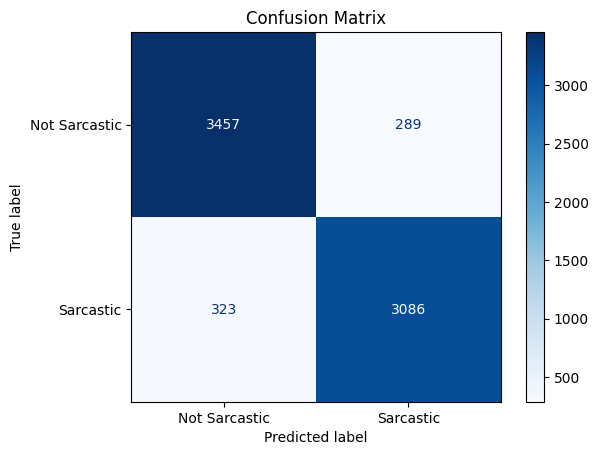


Macro F1 Score: 0.9142
Weighted F1 Score: 0.9144

--- Script Finished ---


In [ ]:
# --- Feature Generation (using fine-tuned BERT for downstream task) ---

# 1. Linguistic Features for TRAIN and TEST sets
print("\nExtracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# Ensure all ling features exist, fill missing with 0 or mean if appropriate
for col in ling_feature_names:
    if col not in df_train.columns:
        print(f"Warning: Linguistic feature '{col}' not found in training data. Filling with 0.")
        df_train[col] = 0
    if col not in df_test.columns:
        print(f"Warning: Linguistic feature '{col}' not found in test data. Filling with 0.")
        df_test[col] = 0

# Handle potential NaN values that might arise if features weren't generated correctly
df_train[ling_feature_names] = df_train[ling_feature_names].fillna(0)
df_test[ling_feature_names] = df_test[ling_feature_names].fillna(0)

X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print("Linguistic TRAIN features shape:", X_ling_train.shape)
print("Linguistic TEST features shape:", X_ling_test.shape)

# 2. Combine Fine-tuned BERT [CLS] + Linguistic Features (Dense) for TRAIN and TEST
print("\nCombining Fine-tuned BERT [CLS] and linguistic features...")
# Use the 'after_ft' embeddings generated earlier
X_gling_train = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test = np.hstack([X_bert_test_after_ft, X_ling_test])
print("Combined BERT+Ling TRAIN shape:", X_gling_train.shape)
print("Combined BERT+Ling TEST shape:", X_gling_test.shape)

# --- Feature Scaling (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nScaling combined BERT+Ling features...")
# Scale only the combined dense features before adding sparse TF-IDF
scaler = StandardScaler()
X_gling_train_scaled = scaler.fit_transform(X_gling_train) # Fit ONLY on training data
X_gling_test_scaled = scaler.transform(X_gling_test)   # Transform test data

# Convert scaled dense features to sparse format for hstack
X_train_sparse_scaled_gling = csr_matrix(X_gling_train_scaled)
X_test_sparse_scaled_gling = csr_matrix(X_gling_test_scaled)
print("Scaled Combined BERT+Ling TRAIN features shape (sparse):", X_train_sparse_scaled_gling.shape)
print("Scaled Combined BERT+Ling TEST features shape (sparse):", X_test_sparse_scaled_gling.shape)

# --- TF-IDF Features (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer()

# Fit TF-IDF ONLY on the training text data
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("\nCombining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled_gling])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled_gling])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\n--- Training Downstream Classifier (Logistic Regression) ---")

lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE)
print("Training Logistic Regression model...")
train_start_time = time.time()
lr.fit(X_train_combined, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating Logistic Regression model on the test set...")
eval_start_time = time.time()
y_pred = lr.predict(X_test_combined)
y_pred_proba = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1 (sarcastic)
print(f"Evaluation finished in {time.time() - eval_start_time:.2f}s")

print("\n--- Classification Results ---")
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions/support
print(classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

print("\nConfusion Matrix:")
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
except ImportError:
    print("Confusion Matrix (sklearn.metrics.ConfusionMatrixDisplay not available):")
    print(confusion_matrix(y_test, y_pred, labels=lr.classes_))


print(f"\nMacro F1 Score: {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

print("\n--- Script Finished ---")

## Distance-Weighted Sampling

https://arxiv.org/abs/1706.07567

Loaded data with 28619 samples.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64
Using device: cuda

Splitting data into train/test sets...
Train set size: 21464, Test set size: 7155

Loading tokenizer and base BERT model: bert-base-uncased

Generating BERT [CLS] embeddings BEFORE fine-tuning...
  Generating embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 37.1s
    Processed batch 100/224 (44.6%) | ETA: 26.5s
    Processed batch 150/224 (67.0%) | ETA: 16.0s
    Processed batch 200/224 (89.3%) | ETA: 5.3s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 49.27s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)

Preparing for contrastive fine-tuning using Distance-Weighted Sampling...
Using Standard Dataset.

--- Starting Contrastive Fine-tuning (Distance-Weighted Sampling) ---

Epoch 1/3
  Batch 25/1341 | Loss: 0.8686 | LR: 3.73e-06 | Frac Active: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757385
[t-SNE] KL divergence after 300 iterations: 2.132796
t-SNE finished for 'before' embeddings.


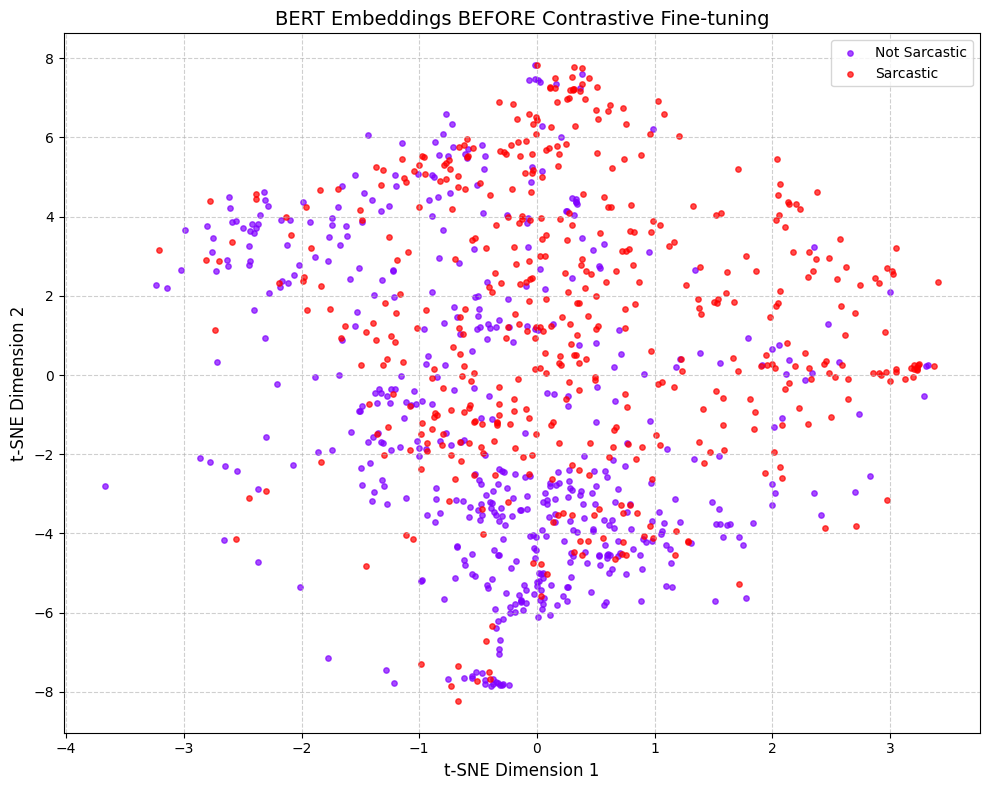


Running t-SNE on embeddings AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.045376


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.932148
[t-SNE] KL divergence after 300 iterations: 1.519276
t-SNE finished for 'after' embeddings.


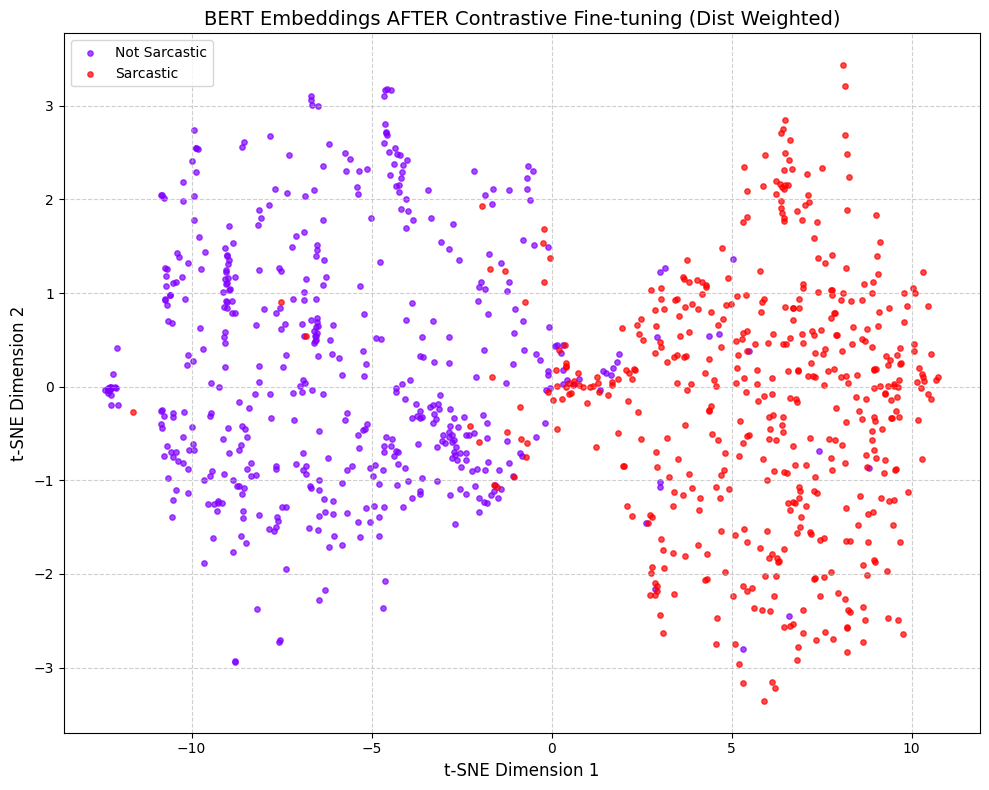

--- Embedding Visualization Finished ---
Script finished (Using Distance-Weighted Sampling).


In [30]:
"""
Sarcasm Detection with Contrastive Fine-tuning using Distance-Weighted Sampling and Visualization

This script demonstrates sarcasm detection using:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss)
   using Distance-Weighted Triplet Sampling within batches.
2. Includes t-SNE visualization of BERT embeddings before and after
   contrastive fine-tuning.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import random
import time

# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
# Batch size might need adjustment based on GPU memory for distance matrix calculation
BATCH_SIZE = 16
RANDOM_STATE = 42

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 3 # Keep low for testing, increase for real training
CONTRASTIVE_LR = 2e-5
CONTRASTIVE_MARGIN = 0.5
PROJECTION_DIM = 256
# Hyperparameter for Distance-Weighted Sampling
# Controls how strongly sampling focuses on closer negatives (higher beta = stronger focus)
DISTANCE_WEIGHTING_BETA = 2.0 # Example value, might need tuning

# Visualization Config
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 300
VISUALIZATION_SAMPLE_SIZE = 1000

# --- Seed Everything ---
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Validate and clean DataFrame
if 'is_sarcastic' not in df.columns or 'clean_headline' not in df.columns:
    raise ValueError("DataFrame must contain 'is_sarcastic' and 'clean_headline' columns.")
df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str).fillna('')
df = df[df['clean_headline'].str.len() > 0]
df = df.reset_index(drop=True)

print(f"Loaded data with {len(df)} samples.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data Split ---
print("\nSplitting data into train/test sets...")
train_indices, test_indices = train_test_split(
    df.index,
    stratify=df['is_sarcastic'],
    random_state=RANDOM_STATE
)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values
print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")

# --- Load Tokenizer and Base BERT Model (for 'before' embeddings) ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME)
bert_model_base.to(device)

# --- Embedding Generation Function ---
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    """Generates [CLS] token embeddings for a list of texts."""
    all_cls_embeddings = []
    model.eval()
    num_samples = len(texts)
    print(f"  Generating embeddings for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()

    for i in range(0, num_samples, batch_size):
        batch_texts = texts[i : i + batch_size]
        # Handle potential empty strings gracefully
        batch_texts = [t if isinstance(t, str) and len(t) > 0 else "[PAD]" for t in batch_texts]
        if not batch_texts:
            continue

        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
        # Extract CLS token embedding (first token of the last layer)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_cls_embeddings.append(cls_embeddings)

        # Progress Logging
        if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches:
            progress = (i // batch_size + 1) / num_batches
            elapsed = time.time() - start_time
            eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
            print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")

    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")

    if not all_cls_embeddings:
        # Handle empty input case
        hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768
        return np.array([]).reshape(0, hidden_size)

    return np.vstack(all_cls_embeddings)

# --- Generate Embeddings BEFORE Fine-tuning ---
print("\nGenerating BERT [CLS] embeddings BEFORE fine-tuning...")
X_bert_test_before_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(),
    bert_model_base,
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE * 2 # Can use larger batch for inference
)
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)

# --- Contrastive Learning Setup ---

# --- Dataset Class ---
# Standard dataset returning tokenized text and label.
# Used for batch-based mining methods like Distance-Weighted.
class SarcasmDataset(Dataset):
    """ Standard dataset returning tokenized text and label. """
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = dataframe['clean_headline'].tolist()
        self.labels = dataframe['is_sarcastic'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=self.max_length
        )
        # Remove the batch dimension added by the tokenizer for single items
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        return inputs, torch.tensor(label, dtype=torch.long)


# --- Contrastive Model Wrapper ---
class ContrastiveBERT(nn.Module):
    """ Wrapper for BERT model with optional projection head. """
    def __init__(self, bert_model, projection_dim=None):
        super().__init__()
        self.bert = bert_model
        self.projection_dim = projection_dim
        self.config = bert_model.config # Store config for hidden size

        if self.projection_dim:
            # Define the projection head
            self.projection_head = nn.Sequential(
                nn.Linear(self.config.hidden_size, self.config.hidden_size),
                nn.ReLU(),
                nn.Linear(self.config.hidden_size, self.projection_dim)
            )
        else:
            # No projection, just use the raw CLS embedding
            self.projection_head = nn.Identity()

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Prepare inputs for the underlying BERT model
        bert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
        # Include token_type_ids only if the model uses them
        if token_type_ids is not None and 'token_type_ids' in self.bert.forward.__code__.co_varnames:
            bert_inputs['token_type_ids'] = token_type_ids

        # Get outputs from the BERT model
        outputs = self.bert(**bert_inputs)
        # Extract the [CLS] token embedding (first token of the last hidden state)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        # Pass the CLS embedding through the projection head (if any)
        projected_embedding = self.projection_head(cls_embedding)
        return projected_embedding


# --- Loss Function: Distance-Weighted Sampling ---
def distance_weighted_triplet_loss(labels, embeddings, margin, beta, squared=False, epsilon=1e-8):
    """
    Computes Triplet Loss with Distance-Weighted Negative Sampling.
    Selects the hardest positive and samples a negative based on distance-based weights.

    Args:
        labels (torch.Tensor): Labels of the batch (batch_size,).
        embeddings (torch.Tensor): Embeddings (batch_size, embed_dim).
        margin (float): Margin for triplet loss.
        beta (float): Scaling factor for distance weights. Higher focuses more on closer negatives.
        squared (bool): If True, use squared Euclidean distance.
        epsilon (float): Small value for numerical stability.

    Returns:
        torch.Tensor: Mean triplet loss over valid triplets.
        float: Fraction of anchors for which valid triplets were formed.
    """
    # Calculate pairwise distances (Euclidean by default)
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
    if squared:
        pairwise_dist = pairwise_dist.pow(2)

    batch_size = labels.size(0)
    anchor_indices = torch.arange(batch_size, device=labels.device)
    # Masks and storage for valid triplet distances
    valid_triplets_mask = torch.zeros(batch_size, dtype=torch.bool, device=labels.device)
    final_pos_dist = torch.zeros(batch_size, device=labels.device)
    final_neg_dist = torch.zeros(batch_size, device=labels.device) # Store dist of *sampled* neg

    num_valid_anchors = 0
    for i in range(batch_size): # Iterate through each potential anchor
        anchor_label = labels[i]

        # --- Find Hardest Positive ---
        pos_mask = (labels == anchor_label) & (anchor_indices != i)
        # Skip anchor if it has no other positive examples in the batch
        if not torch.any(pos_mask):
            continue

        pos_distances = pairwise_dist[i][pos_mask]
        hardest_positive_dist = torch.max(pos_distances)

        # --- Sample Negative based on Distance Weighting ---
        neg_mask = labels != anchor_label
        # Skip anchor if it has no negative examples in the batch
        if not torch.any(neg_mask):
            continue

        neg_indices = anchor_indices[neg_mask] # Get global indices of negatives
        neg_distances = pairwise_dist[i][neg_mask]

        # Calculate weights: exp(-beta * distance)
        # Clamp distance to avoid potential inf weights if distance is 0
        weights = torch.exp(-beta * torch.clamp(neg_distances, min=epsilon))

        # Check for invalid weights (e.g., all distances are huge, weights -> 0)
        if torch.sum(weights) < epsilon:
            # Fallback: sample uniformly among negatives if weights are invalid
            # This prevents errors but might not be optimal learning
            print(f"Warning: Near-zero weights for anchor {i}, falling back to uniform negative sampling.")
            sampled_neg_local_idx = torch.randint(0, len(neg_indices), (1,), device=labels.device).item()
        else:
            # Sample one negative index based on calculated weights
            # multinomial requires probabilities, weights don't need explicit normalization here
            sampled_neg_local_idx = torch.multinomial(weights, 1).item()

        # Get the distance of the *sampled* negative
        sampled_neg_dist = neg_distances[sampled_neg_local_idx]

        # Mark this anchor as having a valid triplet and store distances
        valid_triplets_mask[i] = True
        final_pos_dist[i] = hardest_positive_dist
        final_neg_dist[i] = sampled_neg_dist # Use the distance of the sampled negative
        num_valid_anchors += 1

    # Calculate loss only for anchors where a valid triplet was formed
    if num_valid_anchors == 0:
        # Return zero loss if no valid triplets could be formed in the batch
        return torch.tensor(0.0, device=embeddings.device, requires_grad=True), 0.0

    # Calculate triplet loss for valid triplets: max(0, d(a,p) - d(a,n_sampled) + margin)
    valid_mask = valid_triplets_mask # Use the boolean mask directly
    triplet_loss_values = final_pos_dist[valid_mask] - final_neg_dist[valid_mask] + margin
    # Apply ReLU activation (max(0, x)) and calculate mean over valid triplets
    triplet_loss = torch.mean(torch.relu(triplet_loss_values))

    # Calculate the fraction of anchors that resulted in a valid triplet
    fraction_valid_triplets = num_valid_anchors / batch_size

    return triplet_loss, fraction_valid_triplets


# --- Fine-tuning Function ---
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, device, epochs, margin, distance_beta):
    """ Performs contrastive fine-tuning using Distance-Weighted Sampling. """
    model.train()
    start_time = time.time()
    print("\n--- Starting Contrastive Fine-tuning (Distance-Weighted Sampling) ---")

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_frac_active = 0.0 # Fraction of anchors forming valid triplets
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")
        num_batches_processed = 0

        for i, batch_data in enumerate(dataloader):
            optimizer.zero_grad()
            loss = None
            frac_active = 0.0

            # --- Process Batch ---
            inputs, labels = batch_data
            # Need at least 2 samples to potentially find a positive and negative pair
            if len(labels) <= 1:
                print(f"Warning: Skipping batch {i+1} due to size {len(labels)} <= 1.")
                continue

            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            # Get embeddings from the contrastive model
            embeddings = model(**inputs)

            # Calculate Distance-Weighted Loss
            loss, frac_active = distance_weighted_triplet_loss(
                labels, embeddings, margin, beta=distance_beta
            )

            # --- Backpropagation ---
            # Proceed only if loss is valid (not NaN and greater than 0)
            if loss is not None and not torch.isnan(loss) and loss.item() > 0:
                loss.backward()
                # Optional: Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step() # Update learning rate

                epoch_loss += loss.item()
                epoch_frac_active += frac_active
                num_batches_processed += 1
            elif loss is not None and torch.isnan(loss):
                print(f"Warning: Skipping backward pass for batch {i+1} due to NaN loss.")
            # else: Loss is 0 or None, no gradient update needed

            # --- Logging ---
            if (i + 1) % 25 == 0 or i == len(dataloader) - 1:
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {i+1}/{len(dataloader)} | "
                      f"Loss: {loss.item() if loss is not None else 0.0:.4f} | "
                      f"LR: {current_lr:.2e} | "
                      f"Frac Active: {frac_active:.3f}")

        # --- Epoch Summary ---
        avg_epoch_loss = epoch_loss / num_batches_processed if num_batches_processed > 0 else 0
        avg_frac_active = epoch_frac_active / num_batches_processed if num_batches_processed > 0 else 0
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} finished. "
              f"Avg Loss: {avg_epoch_loss:.4f} | "
              f"Avg Frac Active: {avg_frac_active:.3f} | "
              f"Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"--- Contrastive Fine-tuning Finished ({total_time:.2f}s) ---")


# --- Prepare for Contrastive Fine-tuning ---
print("\nPreparing for contrastive fine-tuning using Distance-Weighted Sampling...")

# Instantiate the standard dataset
train_dataset = SarcasmDataset(df_train, tokenizer, MAX_LENGTH)
print("Using Standard Dataset.")

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set to 0 for simplicity, increase if I/O is bottleneck
    pin_memory=True if device == torch.device("cuda") else False,
    drop_last=True # Important for batch methods to ensure sufficient samples for distances
)

# Create a *new* model instance for fine-tuning
bert_model_to_finetune = AutoModel.from_pretrained(BERT_MODEL_NAME)
contrastive_model = ContrastiveBERT(bert_model_to_finetune, projection_dim=PROJECTION_DIM).to(device)

# Optimizer and Scheduler
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
total_steps = len(train_dataloader) * CONTRASTIVE_EPOCHS
# Use a small portion of steps for warmup (e.g., 10% of first epoch)
num_warmup_steps = int(0.1 * len(train_dataloader))
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# --- Run Contrastive Fine-tuning ---
fine_tune_bert_contrastive(
    model=contrastive_model,
    dataloader=train_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=CONTRASTIVE_EPOCHS,
    margin=CONTRASTIVE_MARGIN,
    distance_beta=DISTANCE_WEIGHTING_BETA
)

# Extract the fine-tuned base BERT model (without projection head)
fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval() # Set to evaluation mode
fine_tuned_base_bert_model.to(device) # Ensure it's on the correct device

# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings for TRAIN set...")
X_bert_train_after_ft = get_bert_cls_embeddings(
    df_train['clean_headline'].tolist(),
    fine_tuned_base_bert_model,
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)

print("\nGenerating Fine-tuned BERT [CLS] embeddings for TEST set...")
X_bert_test_after_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(),
    fine_tuned_base_bert_model,
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE * 2
)
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)

# --- Visualization Section ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")

def plot_embeddings(embeddings_2d, labels, title):
    """ Plots 2D embeddings with labels. """
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}

    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            c=[color], # Scatter expects list of colors
            label=label_map.get(label, f"Class {label}"),
            alpha=0.7,
            s=15 # Smaller points for potentially large datasets
        )

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() # Display the plot

# Check if embeddings were generated successfully
if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization due to empty embeddings.")
else:
    # Sample data points for faster t-SNE if needed
    embeddings_to_tsne_before = X_bert_test_before_ft
    embeddings_to_tsne_after = X_bert_test_after_ft
    labels_for_plot = y_test

    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
        print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
        if actual_sample_size != VISUALIZATION_SAMPLE_SIZE:
            print(f"Warning: Sample size adjusted to {actual_sample_size}.")
        try:
            sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)
            embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
            embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
            labels_for_plot = y_test[sample_indices]
        except ValueError as e:
            print(f"Error during sampling for t-SNE: {e}. Skipping visualization.")
            embeddings_to_tsne_before = None # Flag to skip plotting

    # Plotting
    if embeddings_to_tsne_before is not None:
        # Plot embeddings BEFORE fine-tuning
        print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
        tsne_before = TSNE(
            n_components=2,
            random_state=RANDOM_STATE,
            perplexity=TSNE_PERPLEXITY,
            n_iter=TSNE_N_ITER,
            verbose=1,
            n_jobs=-1 # Use all available CPU cores
        )
        try:
            embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
            print("t-SNE finished for 'before' embeddings.")
            plot_embeddings(
                embeddings_2d_before,
                labels_for_plot,
                "BERT Embeddings BEFORE Contrastive Fine-tuning"
            )
        except Exception as e:
            print(f"Error running or plotting t-SNE (before): {e}")

        # Plot embeddings AFTER fine-tuning
        print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
        tsne_after = TSNE(
            n_components=2,
            random_state=RANDOM_STATE,
            perplexity=TSNE_PERPLEXITY,
            n_iter=TSNE_N_ITER,
            verbose=1,
            n_jobs=-1
        )
        try:
            embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
            print("t-SNE finished for 'after' embeddings.")
            plot_embeddings(
                embeddings_2d_after,
                labels_for_plot,
                "BERT Embeddings AFTER Contrastive Fine-tuning (Dist Weighted)"
            )
        except Exception as e:
            print(f"Error running or plotting t-SNE (after): {e}")

print("--- Embedding Visualization Finished ---")
print("Script finished (Using Distance-Weighted Sampling).")


Extracting linguistic features...
Linguistic TRAIN features shape: (21464, 17)
Linguistic TEST features shape: (7155, 17)

Combining Fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling TRAIN shape: (21464, 785)
Combined BERT+Ling TEST shape: (7155, 785)

Scaling combined BERT+Ling features...
Scaled Combined BERT+Ling TRAIN features shape (sparse): (21464, 785)
Scaled Combined BERT+Ling TEST features shape (sparse): (7155, 785)

Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)

Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Training Downstream Classifier (Logistic Regression) ---
Training Logistic Regression model...
Training finished in 11.08s

Evaluating Logistic Regression model on the test set...
Evaluation finished in 0.05s

--- Classification Results ---

Classification Report:
               precision    recall

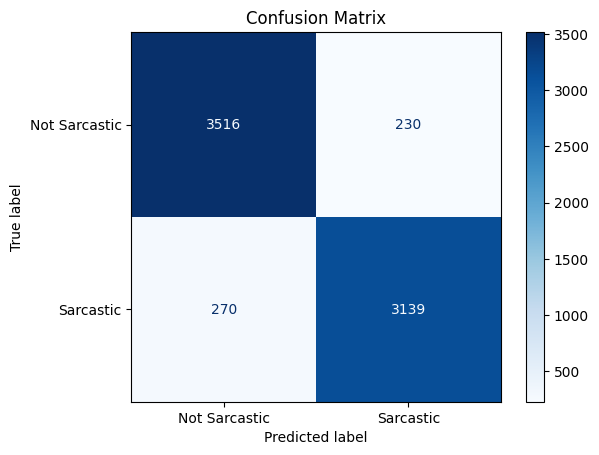


Macro F1 Score: 0.9299
Weighted F1 Score: 0.9301

--- Script Finished ---


In [31]:
# --- Feature Generation (using fine-tuned BERT for downstream task) ---

# 1. Linguistic Features for TRAIN and TEST sets
print("\nExtracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# Ensure all ling features exist, fill missing with 0 or mean if appropriate
for col in ling_feature_names:
    if col not in df_train.columns:
        print(f"Warning: Linguistic feature '{col}' not found in training data. Filling with 0.")
        df_train[col] = 0
    if col not in df_test.columns:
        print(f"Warning: Linguistic feature '{col}' not found in test data. Filling with 0.")
        df_test[col] = 0

# Handle potential NaN values that might arise if features weren't generated correctly
df_train[ling_feature_names] = df_train[ling_feature_names].fillna(0)
df_test[ling_feature_names] = df_test[ling_feature_names].fillna(0)

X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print("Linguistic TRAIN features shape:", X_ling_train.shape)
print("Linguistic TEST features shape:", X_ling_test.shape)

# 2. Combine Fine-tuned BERT [CLS] + Linguistic Features (Dense) for TRAIN and TEST
print("\nCombining Fine-tuned BERT [CLS] and linguistic features...")
# Use the 'after_ft' embeddings generated earlier
X_gling_train = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test = np.hstack([X_bert_test_after_ft, X_ling_test])
print("Combined BERT+Ling TRAIN shape:", X_gling_train.shape)
print("Combined BERT+Ling TEST shape:", X_gling_test.shape)

# --- Feature Scaling (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nScaling combined BERT+Ling features...")
# Scale only the combined dense features before adding sparse TF-IDF
scaler = StandardScaler()
X_gling_train_scaled = scaler.fit_transform(X_gling_train) # Fit ONLY on training data
X_gling_test_scaled = scaler.transform(X_gling_test)   # Transform test data

# Convert scaled dense features to sparse format for hstack
X_train_sparse_scaled_gling = csr_matrix(X_gling_train_scaled)
X_test_sparse_scaled_gling = csr_matrix(X_gling_test_scaled)
print("Scaled Combined BERT+Ling TRAIN features shape (sparse):", X_train_sparse_scaled_gling.shape)
print("Scaled Combined BERT+Ling TEST features shape (sparse):", X_test_sparse_scaled_gling.shape)

# --- TF-IDF Features (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer()

# Fit TF-IDF ONLY on the training text data
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("\nCombining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled_gling])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled_gling])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\n--- Training Downstream Classifier (Logistic Regression) ---")

lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE)
print("Training Logistic Regression model...")
train_start_time = time.time()
lr.fit(X_train_combined, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating Logistic Regression model on the test set...")
eval_start_time = time.time()
y_pred = lr.predict(X_test_combined)
y_pred_proba = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1 (sarcastic)
print(f"Evaluation finished in {time.time() - eval_start_time:.2f}s")

print("\n--- Classification Results ---")
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions/support
print(classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

print("\nConfusion Matrix:")
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
except ImportError:
    print("Confusion Matrix (sklearn.metrics.ConfusionMatrixDisplay not available):")
    print(confusion_matrix(y_test, y_pred, labels=lr.classes_))


print(f"\nMacro F1 Score: {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

print("\n--- Script Finished ---")

## Neural Network (to boost F1 scores)

_Not the focus but to see how far we can take the model performance to_

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_combined.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_combined.toarray(), dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### No hidden layer

In [43]:
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Sequential(
#             nn.Linear(input_dim, 2)
#         )

#     def forward(self, x):
#         x = self.fc1(x)
#         return x


In [44]:
#Uncomment as needed to use it

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.fc1(x)
        return x


In [45]:
print(X_train_combined.shape[1])
nn_model = SimpleNN(X_train_combined.shape[1])
nn_model.to(device)
print(nn_model(torch.randn(32, X_train_combined.shape[1]).to(device)).shape)

23968
torch.Size([32, 2])


In [46]:
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [47]:
def evaluate(model, test_loader, verbose, device):
  with torch.no_grad():
    model.to(device)
    model.eval()
    y_pred = []
    y = []
    for input, output in test_loader:
      input = input.to(device)
      output = output.to(device)
      preds = torch.argmax(model(input), dim=1)
      y_pred.extend(preds.cpu().numpy())
      y.extend(output.cpu().numpy())
    if verbose:
      pass
      # print(classification_report(y, y_pred))
      # print(confusion_matrix(y, y_pred))
    macro_f1_score = f1_score(y, y_pred, average='macro')
    print(f"Macro Test F1: {macro_f1_score:.4f}")
    return macro_f1_score

evaluate(nn_model, test_loader, True, device)




Macro Test F1: 0.4689


0.46892028056501356

In [48]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
patience = 8

def train(model, train_loader, device, epochs=100):
    model.to(device)
    best_test_f1 = 0
    curr = 0
    for i in range(epochs):
        model.train()
        y = []
        y_p = []
        running_loss = 0

        for input, output in train_loader:
            input = input.to(device)
            output = output.to(device)

            y_pred = model(input)
            y_pred_labels = torch.argmax(y_pred, dim=1)

            y_p.extend(y_pred_labels.cpu().numpy())
            y.extend(output.cpu().numpy())

            optimizer.zero_grad()
            loss = loss_fn(y_pred, output)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        macro_train_f1 = f1_score(y, y_p, average='macro')
        print(f"\nEpoch {i+1}/{epochs}")
        print(f"Train Loss: {running_loss:.4f}")
        print(f"Macro Training F1: {macro_train_f1:.4f}")

        # Evaluate on test set
        macro_test_f1 = evaluate(model, test_loader, True, device)
        scheduler.step(macro_test_f1)

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr:.6f}")

        if macro_test_f1 > best_test_f1:
          curr = 0
          best_test_f1 = macro_test_f1
          print("New best model! Saving...")
          torch.save(model.state_dict(), "best_model.pt")
        else:
          curr += 1
          if curr >= patience:
            print("Early Stopping..")
            break


train(nn_model, train_loader, device)







Epoch 1/100
Train Loss: 15.5748
Macro Training F1: 0.9946
Macro Test F1: 0.9318
Current Learning Rate: 0.001000
New best model! Saving...

Epoch 2/100
Train Loss: 12.0295
Macro Training F1: 0.9957
Macro Test F1: 0.9325
Current Learning Rate: 0.001000
New best model! Saving...

Epoch 3/100
Train Loss: 10.6622
Macro Training F1: 0.9963
Macro Test F1: 0.9325
Current Learning Rate: 0.001000

Epoch 4/100
Train Loss: 9.7625
Macro Training F1: 0.9965
Macro Test F1: 0.9329
Current Learning Rate: 0.001000
New best model! Saving...

Epoch 5/100
Train Loss: 8.5157
Macro Training F1: 0.9972
Macro Test F1: 0.9309
Current Learning Rate: 0.001000

Epoch 6/100
Train Loss: 8.0453
Macro Training F1: 0.9972
Macro Test F1: 0.9308
Current Learning Rate: 0.001000

Epoch 7/100
Train Loss: 6.5971
Macro Training F1: 0.9976
Macro Test F1: 0.9327
Current Learning Rate: 0.001000

Epoch 8/100
Train Loss: 5.7494
Macro Training F1: 0.9979
Macro Test F1: 0.9332
Current Learning Rate: 0.001000
New best model! Saving.

In [50]:
tmp = SimpleNN(X_train_combined.shape[1])
tmp.load_state_dict(torch.load("best_model.pt"))
evaluate(tmp, test_loader, True, device)

Macro Test F1: 0.9332


0.9331806698901489